# Team Based Model

## Imports

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, LogisticRegression, ElasticNet
from sklearn.linear_model import Ridge, Lasso, SGDClassifier
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import sklearn.model_selection

from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix
import pickle


from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [11]:
def load_team_data(seasons):
    """Loads basic, advanced, and scoring boxscores from
    seasons 2000-2019 and merges them into one dataframe
    """


    basic_gls_all, adv_gls_all, scoring_gls_all = [], [], []
    for season in seasons:
        basic_gls = pd.read_csv('../data/basic_team_boxscores/team_gamelogs_{}.csv'.format(season))
        basic_gls_all.append(basic_gls)

        adv_gls = pd.read_csv('../data/advanced_team_boxscores/team_advanced_boxscores_{}.csv'.format(season))
        adv_gls_all.append(adv_gls)

        scoring_gls = pd.read_csv('../data/scoring_team_boxscores/team_scoring_boxscores_{}.csv'.format(season))
        scoring_gls_all.append(scoring_gls)

    basic_gls_all_df = pd.concat(basic_gls_all)
    adv_gls_all_df = pd.concat(adv_gls_all)
    scoring_gls_all_df = pd.concat(scoring_gls_all)

    temp = pd.merge(basic_gls_all_df, adv_gls_all_df, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls_all_df, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'])
    return full_df

seasons = ['200{}-0{}'.format(x, x+1) if x != 9 else '2009-10' for x in range(0, 10)]
seasons2 = ['20{}-{}'.format(x, x+1) for x in range(10, 20)]
seasons.extend(seasons2)
print(seasons)
team_data = load_team_data(seasons)

['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']


In [12]:
def load_2020_data():
    """Loads basic, advanced, and scoring boxscores from
    2020 season and merges them into one dataframe
    """

    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_2020-21.csv')

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_2020-21.csv')

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_2020-21.csv')

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'])
    
    full_df['SEASON_YEAR'] = '2020-21'
    return full_df

df_2020 = load_2020_data()
df_2020

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,SEASON_YEAR
0,22020,1610612747,LAL,Los Angeles Lakers,22000002,2020-12-22,LAL vs. LAC,L,240,38,81,0.469,9,29,0.310,24,31,0.774,8,37,45,22,4,2,19,20,109,-7,103.2,104.8,109.1,111.5,-5.9,-6.7,0.579,1.16,16.2,0.250,0.731,0.510,17.986,18.3,0.525,0.576,1.0,0.199,106.00,104.0,86.67,104,0.509,0.642,0.358,0.532,0.183,0.248,0.110,0.220,0.174,0.349,0.586,0.414,0.556,0.444,0.579,0.421,2020-21
1,22020,1610612746,LAC,LA Clippers,22000002,2020-12-22,LAC @ LAL,W,240,44,93,0.473,14,40,0.350,14,19,0.737,11,29,40,22,10,3,16,29,116,7,109.1,111.5,103.2,104.8,5.9,6.7,0.500,1.38,15.8,0.269,0.750,0.490,15.043,15.4,0.548,0.572,1.0,0.198,106.00,104.0,86.67,104,0.491,0.570,0.430,0.517,0.086,0.362,0.138,0.121,0.138,0.431,0.433,0.567,0.643,0.357,0.500,0.500,2020-21
2,22020,1610612744,GSW,Golden State Warriors,22000001,2020-12-22,GSW @ BKN,L,240,37,99,0.374,10,33,0.303,15,23,0.652,13,34,47,26,6,6,18,24,99,-26,86.8,88.4,110.5,111.6,-23.8,-23.2,0.703,1.44,17.0,0.281,0.685,0.466,15.773,16.1,0.424,0.454,1.0,0.201,113.60,112.0,93.33,112,0.350,0.667,0.333,0.545,0.101,0.303,0.121,0.152,0.192,0.444,0.630,0.370,0.900,0.100,0.703,0.297,2020-21
3,22020,1610612751,BKN,Brooklyn Nets,22000001,2020-12-22,BKN vs. GSW,W,240,42,92,0.457,15,35,0.429,26,32,0.813,13,44,57,24,11,7,20,22,125,26,110.5,111.6,86.8,88.4,23.8,23.2,0.571,1.20,16.0,0.315,0.719,0.534,17.687,17.9,0.538,0.589,1.0,0.201,113.60,112.0,93.33,112,0.650,0.620,0.380,0.432,0.064,0.360,0.224,0.208,0.184,0.368,0.481,0.519,0.733,0.267,0.571,0.429,2020-21
4,22020,1610612764,WAS,Washington Wizards,22000013,2020-12-23,WAS @ PHI,L,240,39,85,0.459,13,27,0.481,16,23,0.696,5,35,40,28,7,4,20,26,107,-6,97.2,100.0,104.4,104.6,-7.3,-4.6,0.718,1.40,19.6,0.184,0.720,0.455,18.162,18.7,0.535,0.562,1.0,0.196,109.16,107.5,89.58,107,0.462,0.682,0.318,0.486,0.243,0.364,0.196,0.150,0.159,0.243,0.577,0.423,1.000,0.000,0.718,0.282,2020-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,42020,1610612756,PHX,Phoenix Suns,42000154,2021-05-30,PHX @ LAL,W,240,37,85,0.435,10,35,0.286,16,21,0.762,9,40,49,24,12,4,10,20,100,8,105.0,102.0,94.6,94.8,10.4,7.2,0.649,2.40,18.7,0.170,0.788,0.476,10.500,10.2,0.494,0.531,1.0,0.200,96.24,97.5,81.25,98,0.577,0.588,0.412,0.540,0.100,0.300,0.160,0.160,0.190,0.440,0.519,0.481,1.000,0.000,0.649,0.351,2020-21
2216,42020,1610612751,BKN,Brooklyn Nets,42000114,2021-05-30,BKN @ BOS,W,240,48,83,0.578,16,27,0.593,29,30,0.967,9,27,36,29,8,11,10,28,141,15,145.1,143.9,123.0,129.9,22.1,14.0,0.604,2.90,21.4,0.306,0.627,0.494,10.288,10.2,0.675,0.733,1.0,0.198,99.84,97.5,81.25,98,0.573,0.675,0.325,0.454,0.156,0.340,0.064,0.206,0.128,0.298,0.531,0.469,0.750,0.250,0.604,0.396,2020-21
2217,42020,1610612738,BOS,Boston Celtics,42000114,2021-05-30,BOS vs. BKN,L,240,37,85,0.435,14,41,0.341,38,42,0.905,12,23,35,24,8,4,11,21,126,-15,123.0,129.9,145.1,143.9,-22.1,-14.0,0.649,2.18,17.3,0.373,0.694,0.506,10.734,11.3,0.518,0.609,1.0,0.199,99.84,97.5,81.25,97,0.427,0.518,0.482,0.365,0.111,0.333,0.095,0.302,0.119,0.254,0.522,0.478,0.857,0.143,0.649,0.351,2020-21
2218,42020,1610612746,LAC,LA Clippers,42000174,2021-05-30,LAC @ DAL,W,240,37,77,0.481,13,33,0.394,19,25,0.760,9,44,53,16,7,6,12,25,106,25,116.5,115.2,83.8,86.2,32.7,29.0,0.432,1.33,13.8,0

In [13]:
df = pd.concat([team_data, df_2020])
df

/Users/jordannishimura/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,AST,AST_PCT,AST_RATIO,AST_TOV,BLK,DEF_RATING,DREB,DREB_PCT,EFG_PCT,E_DEF_RATING,E_NET_RATING,E_OFF_RATING,E_PACE,E_TM_TOV_PCT,E_USG_PCT,FG3A,FG3M,FG3_PCT,FGA,FGM,FG_PCT,FTA,FTM,FT_PCT,GAME_DATE,GAME_ID,MATCHUP,MIN,NET_RATING,OFF_RATING,OREB,OREB_PCT,PACE,PACE_PER40,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,PF,PIE,PLUS_MINUS,POSS,PTS,REB,REB_PCT,SEASON_ID,SEASON_YEAR,STL,TEAM_ABBREVIATION,TEAM_ID,TEAM_NAME,TM_TOV_PCT,TOV,TS_PCT,USG_PCT,WL
0,18,0.529,14.1,1.00,7,110.4,27,0.667,0.473,108.1,-8.7,99.4,98.32,18.256,0.197,9,2,0.222,74,34,0.459,40,28,0.700,2000-10-31,20000008,HOU vs. MIN,240,-7.3,103.2,11,0.289,95.5,79.58,0.563,0.000,0.529,0.878,0.122,0.653,0.163,0.061,0.102,0.286,0.204,0.490,0.438,1.000,0.471,17,0.446,-8,95.0,98,38,0.478,22000,2000-01,9,HOU,1610612745,Houston Rockets,18.9,18,0.535,1.0,L
1,29,0.674,20.7,1.81,1,103.2,31,0.711,0.523,99.4,8.7,108.1,98.32,16.320,0.195,11,6,0.545,88,43,0.489,16,14,0.875,2000-10-31,20000008,MIN @ HOU,240,7.3,110.4,13,0.333,95.5,79.58,0.622,1.000,0.674,0.875,0.125,0.698,0.396,0.170,0.085,0.132,0.208,0.302,0.378,0.000,0.326,25,0.554,8,96.0,106,44,0.522,22000,2000-01,7,MIN,1610612750,Minnesota Timberwolves,16.7,16,0.558,1.0,W
2,24,0.774,17.7,1.60,8,87.8,35,0.698,0.382,85.9,-3.5,82.5,99.76,15.084,0.196,10,3,0.300,85,31,0.365,26,17,0.654,2000-10-31,20000002,NJN vs. CLE,240,-4.1,83.7,12,0.276,98.0,81.67,0.750,1.000,0.774,0.882,0.118,0.683,0.171,0.110,0.110,0.207,0.256,0.512,0.250,0.000,0.226,31,0.488,-4,98.0,82,47,0.477,22000,2000-01,9,NJN,1610612751,New Jersey Nets,15.3,15,0.425,1.0,L
3,16,0.500,12.6,0.84,8,83.7,41,0.724,0.423,82.5,3.5,85.9,99.76,18.985,0.202,7,2,0.286,78,32,0.410,32,20,0.625,2000-10-31,20000002,CLE @ NJN,240,4.1,87.8,11,0.302,98.0,81.67,0.467,1.000,0.500,0.910,0.090,0.698,0.279,0.070,0.163,0.233,0.140,0.419,0.533,0.000,0.500,27,0.512,4,98.0,86,52,0.523,22000,2000-01,5,CLE,1610612739,Cleveland Cavaliers,19.4,19,0.467,1.0,W
4,19,0.528,15.6,1.12,4,104.3,26,NaN,0.475,106.1,-15.4,90.7,93.06,18.139,0.199,17,4,0.235,80,36,0.450,13,9,0.692,2000-10-31,20000009,IND @ SAS,240,-13.8,90.4,9,0.239,94.0,78.33,0.469,1.000,0.528,0.788,0.213,0.753,0.447,0.141,0.106,0.106,0.259,0.306,0.531,0.000,0.472,32,0.359,-13,94.0,85,35,NaN,22000,2000-01,5,IND,1610612754,Indiana Pacers,18.1,17,0.496,1.0,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,24,0.649,18.7,2.40,4,94.8,40,0.788,0.494,94.6,10.4,105.0,96.24,10.500,0.200,35,10,0.286,85,37,0.435,21,16,0.762,2021-05-30,42000154,PHX @ LAL,240,7.2,102.0,9,0.170,97.5,81.25,0.519,1.000,0.649,0.588,0.412,0.540,0.100,0.300,0.160,0.160,0.190,0.440,0.481,0.000,0.351,20,0.577,8,98.0,100,49,0.476,42020,2020-21,12,PHX,1610612756,Phoenix Suns,10.2,10,0.531,1.0,W
2216,29,0.604,21.4,2.90,11,129.9,27,0.627,0.675,123.0,22.1,145.1,99.84,10.288,0.198,27,16,0.593,83,48,0.578,30,29,0.967,2021-05-30,42000114,BKN @ BOS,240,14.0,143.9,9,0.306,97.5,81.25,0.531,0.750,0.604,0.675,0.325,0.454,0.156,0.340,0.064,0.206,0.128,0.298,0.469,0.250,0.396,28,0.573,15,98.0,141,36,0.494,42020,2020-21,8,BKN,1610612751,Brooklyn Nets,10.2,10,0.733,1.0,W
2217,24,0.649,17.3,2.18,4,143.9,23,0.694,0.518,145.1,-22.1,123.0,99.84,10.734,0.199,41,14,0.341,85,37,0.435,42,38,0.905,2021-05-30,42000114,BOS vs. BKN,240,-14.0,129.9,12,0.373,97.5,81.25,0.522,0.857,0.649,0.518,0.482,0.365,0.111,0.333,0.095,0.302,0.119,0.254,0.478,0.143,0.351,21,0.427,-15,97.0,126,35,0.506,42020,2020-21,8,BOS,1610612738,Boston Celtics,11.3,11,0.609,1.0,L
2218,16,0.432,13.8,1.33,6,86.2,44,0.746,0.565,83.8,32.7,116.5,93.84,13.187,0.200,33,13,0.394,77,37,0.481,25,19,0.760,2021-05-30,42000174,LAC @ DAL,240,29.0,115.2,9,0.205,93.0,77.50,0.208,0.846,0.432,0.571,0.

In [14]:
from src.data.make_team_dataset import clean_team_data

clean_team_df = clean_team_data(df)



In [15]:
from src.data.make_team_dataset import prep_for_aggregation
ready_for_agg_df = prep_for_aggregation(clean_team_df)
ready_for_agg_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,2020-21,42020,1610612756,PHX,Phoenix Suns,42000154,2021-05-30,PHX @ LAL,0,100,8,1,240,1,27,50,10,35,16,21,9,40,49,24,12,4,10,20,100,8,105.0,102.0,94.6,94.8,10.4,7.2,98.0,0.577,10,16,19,44,14,12,10,0
2216,2020-21,42020,1610612751,BKN,Brooklyn Nets,42000114,2021-05-30,BKN @ BOS,0,141,15,1,240,1,32,56,16,27,29,30,9,27,36,29,8,11,10,28,141,15,145.1,143.9,123.0,129.9,22.1,14.0,98.0,0.573,21,9,18,42,16,15,12,4
2217,2020-21,42020,1610612738,BOS,Boston Celtics,42000114,2021-05-30,BOS vs. BKN,1,126,-15,0,240,0,23,44,14,41,38,42,12,23,35,24,8,4,11,21,126,-15,123.0,129.9,145.1,143.9,-22.1,-14.0,97.0,0.427,13,11,14,32,12,10,11,2
2218,2020-21,42020,1610612746,LAC,LA Clippers,42000174,2021-05-30,LAC @ DAL,0,106,25,1,240,1,24,44,13,33,19,25,9,44,53,16,7,6,12,25,106,25,116.5,115.2,83.8,86.2,32.7,29.0,92.0,0.701,4,16,4,43,4,19,10,2


## Add Betting Data 

In [16]:
from src.data.make_betting_dataset import clean_spread_data

spread_df = pd.read_csv('../data/all_spreads_sbr.csv', parse_dates=['game_date'])
clean_spread = clean_spread_data(spread_df)
clean_spread
clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode', 'away_spread_mode']]

,away_team,home_team,game_date,home_spread_mode,away_spread_mode
0,CHI,MIA,2006-10-31,-4.5,4.5
1,PHX,LAL,2006-10-31,8.0,-8.5
2,TOR,BKN,2006-11-01,-7.5,7.0
3,NYK,MEM,2006-11-01,-5.0,5.0
4,ATL,PHI,2006-11-01,-6.0,5.5
...,...,...,...,...,...
18841,ORL,ATL,2021-04-20,-12.5,12.0
18842,BKN,NOP,2021-04-20,-3.0,3.0
18843,CHA,NYK,2021-04-20,-5.0,5.0
18844,MIN,SAC,2021-04-20,-3.5,3.5


In [17]:
from src.data.make_betting_dataset import clean_moneyline_data

ml_df = pd.read_csv('../data/all_moneylines_sbr.csv', parse_dates=['game_date'])
clean_moneylines = clean_moneyline_data(ml_df)



In [18]:
clean_moneylines

,away_team,home_team,game_date,away_ml1,away_ml2,away_ml3,away_ml4,home_ml1,home_ml2,home_ml3,home_ml4
0,CHI,MIA,2006-10-31,+180,NaN,+180,NaN,-220,NaN,-210,NaN
1,PHX,LAL,2006-10-31,-380,NaN,-350,NaN,+290,NaN,+290,NaN
2,ATL,PHI,2006-11-01,+200,NaN,+200,NaN,-240,NaN,-240,NaN
3,NOP,BOS,2006-11-01,+140,NaN,+140,NaN,-160,NaN,-160,NaN
4,TOR,BKN,2006-11-01,NaN,NaN,+275,NaN,NaN,NaN,-325,NaN
...,...,...,...,...,...,...,...,...,...,...,...
18825,MIL,MIA,2021-05-29,-178,-175,-10000,-190,+158,+151,+4000,+165
18826,BKN,BOS,2021-05-30,-450,-475,-550,-475,+360,+367,+375,+375
18827,LAC,DAL,2021-05-30,-168,-166,-170,-165,+148,+145,+150,+145
18828,NYK,ATL,2021-05-30,+175,+183,+175,+175,-205,-219,-210,-205


In [19]:
def convert_to_float(x):
    if x[0] == '+':
        return x[1:]
    elif x[0] == '-':
        return int(x)
    else:
        return np.nan

In [20]:
for col in clean_moneylines.columns[3:11]:
    clean_moneylines[col] = clean_moneylines[col].astype(str).apply(convert_to_float)
    clean_moneylines[col] = clean_moneylines[col].astype(float)
    
clean_moneylines['away_ml_mode'] = clean_moneylines.iloc[:, 3:7].mode(axis=1)[0]
clean_moneylines['home_ml_mode'] = clean_moneylines.iloc[:, 7:11].mode(axis=1)[0]

clean_moneylines

,away_team,home_team,game_date,away_ml1,away_ml2,away_ml3,away_ml4,home_ml1,home_ml2,home_ml3,home_ml4,away_ml_mode,home_ml_mode
0,CHI,MIA,2006-10-31,180.0,NaN,180.0,NaN,-220.0,NaN,-210.0,NaN,180.0,-220.0
1,PHX,LAL,2006-10-31,-380.0,NaN,-350.0,NaN,290.0,NaN,290.0,NaN,-380.0,290.0
2,ATL,PHI,2006-11-01,200.0,NaN,200.0,NaN,-240.0,NaN,-240.0,NaN,200.0,-240.0
3,NOP,BOS,2006-11-01,140.0,NaN,140.0,NaN,-160.0,NaN,-160.0,NaN,140.0,-160.0
4,TOR,BKN,2006-11-01,NaN,NaN,275.0,NaN,NaN,NaN,-325.0,NaN,275.0,-325.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18825,MIL,MIA,2021-05-29,-178.0,-175.0,-10000.0,-190.0,158.0,151.0,4000.0,165.0,-10000.0,151.0
18826,BKN,BOS,2021-05-30,-450.0,-475.0,-550.0,-475.0,360.0,367.0,375.0,375.0,-475.0,375.0
18827,LAC,DAL,2021-05-30,-168.0,-166.0,-170.0,-165.0,148.0,145.0,150.0,145.0,-170.0,145.0
18828,NYK,ATL,2021-05-30,175.0,183.0,175.0,175.0,-205.0,-219.0,-210.0,-205.0,175.0,-205.0


In [21]:
def add_moneyline_data(df):
    df = df.copy()
    df['home_team'] = df['MATCHUP'].apply(lambda x: x[:3] if 'vs' in x else x[-3:])
    df['away_team'] = df['MATCHUP'].apply(lambda x: x[:3] if '@' in x else x[-3:])
    df[['home_team', 'away_team', 'MATCHUP']]
    
    df = pd.merge(df, clean_moneylines[['away_team', 'home_team', 'game_date', 'away_ml_mode', 'home_ml_mode']], how='left', 
         left_on=['home_team', 'away_team', 'GAME_DATE'], right_on=['home_team', 'away_team', 'game_date'])    

    
    return df


ready_for_agg_df = add_moneyline_data(ready_for_agg_df)


In [22]:
def convert_american_to_decimal(x):
    if x > 0:
        return 1 + x/100
    if x < 0:
        return 1 - (100/x)
    
convert_american_to_decimal(200)


3.0

In [23]:
ready_for_agg_df['away_ml_mode'] = ready_for_agg_df['away_ml_mode'].apply(convert_american_to_decimal)
ready_for_agg_df['home_ml_mode'] = ready_for_agg_df['home_ml_mode'].apply(convert_american_to_decimal)


In [24]:
def add_spread_data(df):
    df = df.copy()
    df['home_team'] = df['MATCHUP'].apply(lambda x: x[:3] if 'vs' in x else x[-3:])
    df['away_team'] = df['MATCHUP'].apply(lambda x: x[:3] if '@' in x else x[-3:])
    df[['home_team', 'away_team', 'MATCHUP']]
    
    df = pd.merge(df, clean_spread[['away_team', 'home_team', 'game_date', 'away_spread_mode', 'home_spread_mode']], how='left', 
         left_on=['home_team', 'away_team', 'GAME_DATE'], right_on=['home_team', 'away_team', 'game_date'])    
    
    df['team_covered'] = df.apply(lambda row: int(row['point_diff'] + row['home_spread_mode'] > 0) 
                                          if row['HOME_GAME'] == 1 else int(row['point_diff'] + row['away_spread_mode'] > 0), axis=1)

    return df


ready_for_agg_df = add_spread_data(ready_for_agg_df)


In [25]:
ready_for_agg_df['ml'] = ready_for_agg_df.apply(lambda row: row['home_ml_mode'] if row['HOME_GAME'] == 1 else row['away_ml_mode'], axis=1)

ready_for_agg_df['spread'] = ready_for_agg_df.apply(lambda row: row['home_spread_mode'] if row['HOME_GAME'] == 1 else -row['home_spread_mode'], axis=1)


ready_for_agg_df.iloc[:, 10:]

,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM,home_team,away_team,game_date_x,away_ml_mode,home_ml_mode,game_date_y,away_spread_mode,home_spread_mode,team_covered,ml,spread
0,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2,HOU,MIN,NaT,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN
1,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0,HOU,MIN,NaT,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN
2,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0,BKN,CLE,NaT,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN
3,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0,BKN,CLE,NaT,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN
4,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0,SAS,IND,NaT,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53541,8,1,240,1,27,50,10,35,16,21,9,40,49,24,12,4,10,20,100,8,105.0,102.0,94.6,94.8,10.4,7.2,98.0,0.577,10,16,19,44,14,12,10,0,LAL,PHX,2021-05-30,3.350000,1.3125,2021-05-30,6.5,-6.5,1,3.350000,6.5
53542,15,1,240,1,32,56,16,27,29,30,9,27,36,29,8,11,10,28,141,15,145.1,143.9,123.0,129.9,22.1,14.0,98.0,0.573,21,9,18,42,16,15,12,4,BOS,BKN,2021-05-30,1.210526,4.7500,2021-05-30,-9.0,9.0,1,1.210526,-9.0
53543,-15,0,240,0,23,44,14,41,38,42,12,23,35,24,8,4,11,21,126,-15,123.0,129.9,145.1,143.9,-22.1,-14.0,97.0,0.427,13,11,14,32,12,10,11,2,BOS,BKN,2021-05-30,1.210526,4.7500,2021-05-30,-9.0,9.0,0,4.750000,9.0
53544,25,1,240,1,24,44,13,33,19,25,9,44,53,16,7,6,12,25,106,25,116.5,115.2,83.8,86.2,32.7,29.0,92.0,0.701,4,16,4,43,4,19,10,2,DAL,LAC,2021-05-30,1.588235,2.4500,2021-05-30,-3.5,3.5,1,1.588235,-3.5


In [26]:
ready_for_agg_df.loc[ready_for_agg_df['SEASON_YEAR']=='2006-07'].to_csv("merged_data_full.csv", index=False)

In [27]:
from src.data.make_team_dataset import create_matchups

matchups = create_matchups(ready_for_agg_df)
matchups

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,E_DEF_RATING_team,E_NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,team_covered_team,ml_team,spread_team,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,E_DEF_RATING_opp,E_NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,team_covered_opp
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,108.1,-8.7,95.0,0.446,15,9,19,48,18,14,0,2,0,NaN,NaN,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,99.4,8.7,96.0,0.554,41,9,22,32,23,13,6,0,0
2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,99.4,8.7,96.0,0.554,41,9,22,32,23,13,6,0,0,NaN,NaN,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,108.1,-8.7,95.0,0.446,15,9,19,48,18,14,0,2,0
5,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,85.9,-3.5,98.0,0.488,14,9,20,41,21,7,3,0,0,NaN,NaN,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,82.5,3.5,98.0,0.512,23,14,12,36,14,15,2,0,0
6,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,82.5,3.5,98.0,0.512,23,14,12,36,14,15,2,0,0,NaN,NaN,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,85.9,-3.5,98.0,0.488,14,9,20,41,21,7,3,0,0
9,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,106.1,-15.4,94.0,0.359,37,9,22,26,15,16,4,0,0,NaN,NaN,1,29,56,4,8,28,35,5,32,37,17,6,4,18,22,98,13,106.1,90.7,15.4,94.0,0.641,42,5,14,15,12,16,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107082,2020-21,42020,1610612756,PHX,Phoenix Suns,42000154,2021-05-30,PHX @ LAL,0,100,8,1,1,27,50,10,35,16,21,9,40,49,24,12,4,10,20,100,8,105.0,94.6,10.4,98.0,0.577,10,16,19,44,14,12,10,0,1,3.350000,6.5,0,19,41,13,40,15,21,9,41,50,19,3,5,16,18,92,-8,94.6,105.0,-10.4,97.0,0.423,2,12,11,35,7,11,10,2,0
107085,2020-21,42020,1610612751,BKN,Brooklyn Nets,42000114,2021-05-30,BKN @ BOS,0,141,15,1,1,32,56,16,27,29,30,9,27,36,29,8,11,10,28,141,15,145.1,123.0,22.1,98.0,0.573,21,9,18,42,16,15,12,4,1,1.210526,-9.0,0,23,44,14,41,38,42,12,23,35,24,8,4,11,21,126,-15,123.0,145.1,-22.1,97.0,0.427,13,11,14,32,12,10,11,2,0
107086,2020-21,42020,1610612738,BOS,Boston Celtics,42000114,2021-05-30,BOS vs. BKN,1,126,-15,0,0,23,44,14,41,38,42,12,23,35,24,8,4,11,21,126,-15,123.0,145.1,-22.1,97.0,0.427,13,11,14,32,12,10,11,2,0,4.750000,9.0,1,32,56,16,27,29,30,9,27,36,29,8,11,10,28,141,15,145.1,123.0,22.1,98.0,0.573,21,9,18,42,16,15,12,4,1
107089,2020-21,42020,1610612746,LAC,LA Clippers,42000174,2021-05-30,LAC @ DAL,0,106,25,1,1,24,44,13,33,19,25,9,44,53,16,7,6,12,25,106,25,116.5,83.8,32.7,92.0,0.701,4,16,4,43,4,19,10,2,1,1.588235,-3.5,0,26,59,5,30,14,22,10,31,41,15,3,1,8,20,81,-25,83.8,116.5,-32.7,94.0,0.299,9,3,11,42,12,13,3,2,0


In [28]:
matchups.columns

Index(['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'RECORD_team', 'FG2M_team', 'FG2A_team', 'FG3M_team',
       'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team', 'DREB_team',
       'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team',
       'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
       'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
       'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
       'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team', 'team_covered_team',
       'ml_team', 'spread_team', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp',
       'FG3M_opp', 'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp',
       'REB_opp', 'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp',
       'PTS_opp', 'PLUS_MINUS_opp'

In [29]:
def get_team_and_opp_ewm(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
        
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'ml_team', 'spread_team', 'team_covered_team',
        'RECORD_team', 'FG2M_team', 'FG2A_team', 'FG3M_team',
       'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team', 'DREB_team',
       'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team',
       'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
       'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
       'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
       'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team', 'team_covered_opp', 
       'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp', 'FG3A_opp', 'FTM_opp',
       'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp', 'AST_opp', 'STL_opp', 
       'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp',
       'E_OFF_RATING_opp', 'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp',
       'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp',
       'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp', 'AST_3PM_opp', 
        'UAST_3PM_opp']]



    team_dfs = []
    for season in tqdm(df['SEASON_YEAR_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            record_team = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec_team = team_df['team_covered_team'].shift(1).expanding().mean()
            
            records = pd.DataFrame({'WL_record':record_team,
                                   'ATS_record':ATS_rec_team})
            
            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)
            
            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df

avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=5, span=19)

Progress: 100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


In [30]:
avg_data_ewm_19

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,ml_team,spread_team,team_covered_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,E_DEF_RATING_team,E_NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,team_covered_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,E_DEF_RATING_opp,E_NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,WL_record,ATS_record
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,0.000000
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53541,2020-21,22020,1610612740,NOP,New Orleans Pelicans,22001020,2021-05-09,NOP @ CHA,0,112,2,1,2.260000,3.0,0.533631,0.463410,32.835113,62.176326,9.669893,29.566920,20.163375,27.414852,12.261805,37.505184,49.766989,26.628228,8.900074,4.536834,15.329666,17.760303,114.843278,1.253326,107.523021,107.099743,0.422757,105.188901,0.519972,8.758997,14.208512,16.649715,55.916619,17.395964,14.645903,8.665496,0.673264,0.393399,0.536590,27.517852,52.169402,13.886353,38.531292,16.895188,21.211449,9.156162,35.580451,44.736613,24.847333,8.403087,6.184819,15.296346,22.092479,113.589953,-1.253326,107.099743,107.523021,-0.422757,105.593313,0.480028,8.454559,14.455904,17.561019,45.452779,13.040309,13.712640,11.099334,2.097132,0.439394,0.454545
53542,2020-21,22020,1610612740,NOP,New Orleans Pelicans,22001028,2021-05-10,NOP @ MEM,0,110,-5,0,4.250000,10.0,0.580308,0.517115,32.851616,61.858420,9.903104,30.310868,19.146163,26.872901,12.635946,37.254450,49.8903

In [31]:
avg_data_ewm_19.loc[(avg_data_ewm_19['TEAM_ABBREVIATION_team'] == 'HOU') 
                   & (avg_data_ewm_19['SEASON_YEAR_team'] == '2016-17'), ['MATCHUP_team', 'point_diff_team', 'RECORD_team',
                                                                          'team_covered_team', 'spread_team', 'WL_record', 
                                                                          'ATS_record']].head(20)

# avg_data_ewm_19.iloc[:, 11:]

,MATCHUP_team,point_diff_team,RECORD_team,team_covered_team,spread_team,WL_record,ATS_record
41194,HOU @ LAL,-6,NaN,NaN,-6.0,NaN,NaN
41195,HOU @ DAL,8,NaN,NaN,-2.0,0.000000,0.000000
41196,HOU vs. DAL,1,NaN,NaN,-6.0,0.500000,0.500000
41197,HOU @ CLE,-8,NaN,NaN,9.5,0.666667,0.333333
41198,HOU @ NYK,19,NaN,NaN,1.0,0.500000,0.500000
41199,HOU @ ATL,-15,0.620009,0.641987,3.0,0.600000,0.600000
41200,HOU @ WAS,8,0.487687,0.504974,NaN,0.500000,0.500000
41201,HOU @ SAS,2,0.585887,0.408180,9.0,0.571429,0.428571
41202,HOU vs. SAS,-6,0.658598,0.512094,1.5,0.625000,0.500000
41203,HOU vs. PHI,27,0.551086,0.428497,-11.5,0.555556,0.444444


## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [32]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [33]:
avg_data_ewm_19

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,ml_team,spread_team,team_covered_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,E_DEF_RATING_team,E_NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,team_covered_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,E_DEF_RATING_opp,E_NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,WL_record,ATS_record
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,0.000000
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53541,2020-21,22020,1610612740,NOP,New Orleans Pelicans,22001020,2021-05-09,NOP @ CHA,0,112,2,1,2.260000,3.0,0.533631,0.463410,32.835113,62.176326,9.669893,29.566920,20.163375,27.414852,12.261805,37.505184,49.766989,26.628228,8.900074,4.536834,15.329666,17.760303,114.843278,1.253326,107.523021,107.099743,0.422757,105.188901,0.519972,8.758997,14.208512,16.649715,55.916619,17.395964,14.645903,8.665496,0.673264,0.393399,0.536590,27.517852,52.169402,13.886353,38.531292,16.895188,21.211449,9.156162,35.580451,44.736613,24.847333,8.403087,6.184819,15.296346,22.092479,113.589953,-1.253326,107.099743,107.523021,-0.422757,105.593313,0.480028,8.454559,14.455904,17.561019,45.452779,13.040309,13.712640,11.099334,2.097132,0.439394,0.454545
53542,2020-21,22020,1610612740,NOP,New Orleans Pelicans,22001028,2021-05-10,NOP @ MEM,0,110,-5,0,4.250000,10.0,0.580308,0.517115,32.851616,61.858420,9.903104,30.310868,19.146163,26.872901,12.635946,37.254450,49.8903

In [34]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
full_df_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [35]:
full_df_ewm_19.loc[full_df_ewm_19['rest'] > 11, 'rest'] = 11
full_df_ewm_19['rest'].value_counts()

2.0     29820
1.0     11485
3.0      8309
4.0      2101
5.0       408
6.0       365
7.0       164
8.0       117
9.0       105
11.0       29
10.0       17
Name: rest, dtype: int64

In [36]:
test = full_df_ewm_19[(full_df_ewm_19['TEAM_ABBREVIATION_team'] == 'SAS') & (full_df_ewm_19['SEASON_YEAR_team'] == '2010-11')]
test

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,ml_team,spread_team,team_covered_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,E_DEF_RATING_team,E_NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,team_covered_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,E_DEF_RATING_opp,E_NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,WL_record,ATS_record,rest,OREB_PCT_team,OREB_PCT_opp,DREB_PCT_team,DREB_PCT_opp,REB_PCT_team,REB_PCT_opp,TS_PCT_team,TS_PCT_opp,EFG_PCT_team,EFG_PCT_opp,AST_RATIO_team,AST_RATIO_opp,TOV_PCT_team,TOV_PCT_opp
26319,2010-11,22010,1610612759,SAS,San Antonio Spurs,21000013,2010-10-27,SAS vs. IND,1,122,13,1,1.200000,-9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26320,2010-11,22010,1610612759,SAS,San Antonio Spurs,21000039,2010-10-30,SAS vs. NOP,1,90,-9,0,1.181818,-9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26321,2010-11,22010,1610612759,SAS,San Antonio Spurs,21000046,2010-11-01,SAS @ LAC,0,97,9,1,1.263158,-8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.500000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26322,2010-11,22010,1610612759,SAS,San Antonio Spurs,21000062,2010-11-03,SAS @ PHX,0,112,2,1,1.869565,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,0.666667,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26323,2010-11,22010,1610612759,SAS,San Antonio Spurs,21000084,2010-11-06,SAS vs. HOU,1,124,3,1,1.344828,-6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,0.750000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26324,2010-11,22010,1610612759,SAS,San Antonio Spurs,21000095,2010-11-08,SAS @ CHA,0,95,4,1,1.526316,-4.0,0.577788,0.821982,33.509389,65.450245,7.806623,20.191448,19.210495,25.610754,10.376767,31.610608,41.987375,26.129496,9.829919,4.806842,16.280775,21.107934,109.649142,3.432956,106.334680,104.119326,2.221973,101.125052,0.526152,23.400772,20.293790,20.527728,42.837782,19.043540,13.710044,6.688164,0.338233,0.422212,0.178018,34.240751,69.442651,7.274987,17.393250,15.909721,20.860003,10.889087,30.423604,41.312691,22.163561,7.864985,5.309174,16.659984,21.552734,106.216185,-3.432956,104.119326,106.334680,-2.221973,100.636663,0.473848,23.716100,17.754951,16.571317,43.549803,15.945032,17.295719,5.598520,1.254255,0.8000

In [37]:
full_df_ewm_19

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,ml_team,spread_team,team_covered_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,E_DEF_RATING_team,E_NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,team_covered_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,E_DEF_RATING_opp,E_NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,WL_record,ATS_record,rest,OREB_PCT_team,OREB_PCT_opp,DREB_PCT_team,DREB_PCT_opp,REB_PCT_team,REB_PCT_opp,TS_PCT_team,TS_PCT_opp,EFG_PCT_team,EFG_PCT_opp,AST_RATIO_team,AST_RATIO_opp,TOV_PCT_team,TOV_PCT_opp
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,0.000000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53541,2020-21,22020,1610612740,NOP,New Orleans Pelicans,22001020,2021-05-09,NOP @ CHA,0,112,2,1,2.260000,3.0,0.533631,0.463410,32.835113,62.176326,9.669893,29.566920,20.163375,27.414852,12.261805,37.505184,49.766989,26.628228,8.900074,4.536834,15.329666,17.760303,114.843278,1.253326,107.523021,107.099743,0.422757,105.188901,0.519972,8.758997,14.208512,16.649715,55.916619,17.395964,14.645903,8.665496,0.

In [38]:
full_df_ewm_19.sort_values(['GAME_ID', 'HOME_GAME_team']).iloc[:, 14:]

,team_covered_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,E_DEF_RATING_team,E_NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,team_covered_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,E_DEF_RATING_opp,E_NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,WL_record,ATS_record,rest,OREB_PCT_team,OREB_PCT_opp,DREB_PCT_team,DREB_PCT_opp,REB_PCT_team,REB_PCT_opp,TS_PCT_team,TS_PCT_opp,EFG_PCT_team,EFG_PCT_opp,AST_RATIO_team,AST_RATIO_opp,TOV_PCT_team,TOV_PCT_opp
874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52073,0.376611,0.495533,27.399619,49.940100,13.325522,36.350338,15.872164,18.958582,9.587842,33.556577,43.144419,24.162228,6.947032,4.076768,12.746956,18.211850,110.647970,3.407586,113.318296,109.744365,3.558513,96.151814,0.522669,12.487667,8.579645,13.982099,41.515839,12.645745,13.924934,10.718746,1.847359,0.604850,0.504467,27.889914,51.970348,11.982396,33.827762,15.513367,20.577228,9.734924,31.924304,41.659228,23.080644,6.372059,5.228640,12.735861,18.295502,107.240384,-3.407586,109.744365,113.318296,-3.558513,96.010798,0.477335,8.646363,9.708928,14.277205,46.033446,13.476198,13.621421,8.990392,2.381882,0.643836,0.534247,3.0,0.230965,0.224869,0.775131,0.769035,0.508757,0.491243,0.611576,0.593636,0.549167,0.534552,25.129248,24.039634,11.870976,11.837628
52074,0.338934,0.445960,27.859847,50.046134,13.292957,36.015167,16.085035,19.062767,9.529034,33.200773,42.729807,24.045957,6.952331,3.969047,12.872312,18.590820,111.683599,2.466440,114.356893,111.530663,2.822359,96.336709,0.518400,11.538510,8.921821,14.083931,43.365015,12.481103,14.532691,10.746883,1.762588,0.644382,0.554040,28.101010,51.573149,12.584404,33.844993,15.261927,20.919646,9.161

In [39]:
def compute_matchup_diffs(avg_data):
    avg_data = avg_data.copy(deep=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs_home = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs_home.columns]
    stat_diffs_home.columns = new_cols

    stat_diffs_away = away_teams.iloc[:, 14:] - home_teams.iloc[:, 14:]
    stat_diffs_away.columns = new_cols

    full_df_home = pd.concat([home_teams.iloc[:, :14], stat_diffs_home], axis=1)
    full_df_away = pd.concat([away_teams.iloc[:, :14], stat_diffs_away], axis=1)

    full_df = pd.concat([full_df_home, full_df_away])
    
#     full_df = full_df.dropna()
    full_df = full_df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])

    full_df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

df_ewm_19_diffs = compute_matchup_diffs(full_df_ewm_19)

In [40]:
df_ewm_19_diffs

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,SCORE_team,point_diff_team,WL_team,ml_team,spread_team,team_covered_team_diff,RECORD_team_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,E_DEF_RATING_team_diff,E_NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,team_covered_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,E_NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,WL_record_diff,ATS_record_diff,rest_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff
0,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01,22000,1610612764,WAS,Washington Wizards,20000003,2000-10-31,WAS @ ORL,0,86,-11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53541,2020-21,42020,1610612737,ATL,Atlanta Hawks,42000134,2021-05-30,ATL vs. NYK,1,113

## Add ELO Rating

In [41]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
    
#     print(MOV)
        
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_team, E_opp)
#     print("elo_diff:", elo_diff)
#     print("S_team:", S_team, "S_opp:", S_opp)
#     print("K_team:", K_team, "K_opp:", K_opp)
#     print(K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
#     print(elo_diff, K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [42]:
elo_update(100, 110, 1500, 1700)
get_K(10, 100)

(19.21762252355425, 19.21762252355425)

In [43]:
full_df_ewm_19.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)



In [44]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['point_diff_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [45]:
df_ewm_19_diffs = add_elo_ratings(df_ewm_19_diffs)

progress:: 53546it [03:23, 262.72it/s]


In [46]:
df_ewm_19_diffs

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,SCORE_team,point_diff_team,WL_team,ml_team,spread_team,team_covered_team_diff,RECORD_team_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,E_DEF_RATING_team_diff,E_NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,team_covered_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,E_NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,WL_record_diff,ATS_record_diff,rest_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
0,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1327.005984,1300.000000,1272.994016,0.00
1,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1272.994016,1300.000000,1327.005984,0.00
2,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1308.006053,1300.000000,1291.993947,0.00
3,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1291.993947,1300.000000,1308.006053,0.00
4,2000-01,22000,1610612764,WAS,Washington Wizards,20000003,2000-10-31,WAS @ ORL,0,86,-11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1290.629938,1300.000000,1309.370062,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [47]:
# full_df_ewm_19.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)

df_ewm_19_diffs.loc[df_ewm_19_diffs['TEAM_ABBREVIATION'] == 'PHI', ['TEAM_ABBREVIATION', 'MATCHUP', 'team_rating_i', 'team_rating_n', 'opp_rating_i', 'opp_rating_n']]

,TEAM_ABBREVIATION,MATCHUP,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n
0,PHI,PHI @ NYK,1300.000000,1327.005984,1300.000000,1272.994016
29,PHI,PHI vs. TOR,1327.005984,1332.914995,1287.677892,1281.768881
58,PHI,PHI @ ORL,1332.914995,1342.221210,1292.183757,1282.877542
68,PHI,PHI @ MIA,1342.221210,1347.754482,1311.596565,1306.063292
123,PHI,PHI vs. DET,1347.754482,1354.579151,1279.420554,1272.595884
...,...,...,...,...,...,...
53435,PHI,PHI vs. ORL,1636.847873,1641.081976,1259.018111,1254.784009
53475,PHI,PHI vs. ORL,1641.081976,1643.430736,1254.784009,1252.435248
53495,PHI,PHI vs. WAS,1643.430736,1647.858577,1488.505446,1484.077605
53513,PHI,PHI vs. WAS,1647.858577,1657.636161,1484.077605,1474.300021


In [48]:
# final_df_ewm_19 = pd.merge(full_df_ewm_19, full_df_ewm_19, on=['GAME_ID'])

# final_df_ewm_19 = final_df_ewm_19.loc[final_df_ewm_19['TEAM_ABBREVIATION_x'] != final_df_ewm_19['TEAM_ABBREVIATION_y']]

# final_df_ewm_19 = final_df_ewm_19.drop(columns=['SEASON_YEAR_y','SEASON_ID_y','TEAM_ID_y','TEAM_ABBREVIATION_y',
#                               'TEAM_NAME_y','GAME_DATE_y','MATCHUP_y','HOME_GAME_y', 
#                              'team_elo_pred_y', 'team_rating_i_y', 'team_rating_n_y',
#                              'opp_rating_i_y', 'opp_rating_n_y', 'elo_MOV_pred_y', 'SCORE_team_y',
#                             'ml_team_y', 'spread_team_y', 'point_diff_team_y'])

# final_df_ewm_19

## Helper Functions for Bet Simulations

In [49]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(-20, 350)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(20, 600)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 5
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets


def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            pct = .05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            pct = .04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            pct = .03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            pct = .02
        else:
            pct = .01
            
        selected_bets.at[idx, 'bet_size'] = selected_bets.at[idx, 'bankroll_i'] * pct
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(15, 200)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets


def simulate_bets_kelly(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']
        
        b = 1/1.1
        if selected_bets.loc[idx, 'prob_avg'] > 0.5:
            p = selected_bets.loc[idx, 'prob_avg']
        else:
            p = 1 - selected_bets.loc[idx, 'prob_avg']
        q = 1-p
        
        K = (b*p-q)/b
        if K < 0:
            bet_size=0
        else:
            bet_size=selected_bets.loc[idx, 'bankroll_i']*K
            
        
        selected_bets.loc[idx, 'bet_size'] = bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets

In [50]:
def simulate_bets(selected_bets, unit_size=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [51]:
def simulate_weighted_bets(selected_bets, unit_size=0.01):
    """This function simulates betting 1% of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    
    
    std = abs(selected_bets['model_probability']-0.5).std()
    min_threshold = abs(selected_bets['model_probability'] - 0.5).min()
    print(std)
    
    cond_list = [abs(selected_bets['model_probability']-0.5).between(min_threshold, min_threshold+0.5*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+0.5*std, min_threshold+1*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+1*std, min_threshold+1.5*std),
                abs(selected_bets['model_probability']-0.5) > min_threshold+1.5*std]
    
    choice_list = [1, 2, 3, 4]
    
    selected_bets['weight'] = np.select(cond_list, choice_list)
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        weight = selected_bets.loc[idx, 'weight']
        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size * weight
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [52]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df=df.copy(deep=True)
    
    betting_df = create_betting_df(df, test_probs, test_indices)

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
#     for num in range(1, 4):
#         strat_types = ['home', 'away', 'avg']
#         strat = strat_types[num-1]
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/1000))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-110)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values('expected_profit', ascending=False, inplace=True)
    confidence_thresholds.reset_index(drop=False, inplace=True) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
#         print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold for testset 1:", best_threshold)
        select_bets =  betting_df.loc[~(betting_df['prob_avg'].between(1-best_threshold, best_threshold))]
        print("num_games_bet at threshold:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        best_threshold = 0.5
        print("The except block executed")
    
    return select_bets, confidence_thresholds, best_threshold
    


In [53]:
# # Find ranges of model probability where the win percentage is higher than 52.8
# def find_optimal_confidence_thresholds(df, diff_preds, test_indices):
#     """
#     INPUTS:
#     test_preds: array of class predictions
#     test_indices: indices of full df for the test set 
#     OUTPUTS:
#     select_bets: df of bets at the optimal thresholds
#     best_thresholds: tuple of lower and upper thresholds
    
#     """
#     betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_x', 'MATCHUP_x', 
#                                                  'spread_team_x', 'ml_team_x', 'SCORE_team_x', 
#                                                  'point_diff_team_x']]
#     betting_df.rename(columns={'MATCHUP_x':'MATCHUP',
#                                'HOME_GAME_x':'HOME_GAME',
#                                'spread_team_x':'spread', 
#                               'ml_team_x':'ml', 
#                               'SCORE_team_x':'team_score', 
#                               'point_diff_team_x':'point_diff'}, inplace=True)


#     betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] > 0).astype(int)

#     betting_df['diff_preds'] = diff_preds

#     home_df = betting_df.loc[betting_df['HOME_GAME']==1]
#     away_df = betting_df.loc[betting_df['HOME_GAME']==0]

#     betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

#     betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
#                                  'ml_home', 'ml_away', 'point_diff_home', 
#                                  'cover_home', 'diff_preds_home', 
#                              'diff_preds_away']]

#     betting_df['point_diff_avg'] = (betting_df['diff_preds_home'] - betting_df['diff_preds_away'])/2

#     betting_df['bet_home1'] = ((betting_df['diff_preds_home'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home2'] = ((-1*betting_df['diff_preds_away'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home3'] = ((betting_df['point_diff_avg'] + betting_df['spread_home']) >0).astype(int)

#     betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

#     betting_df['confidence_pred1'] = betting_df['diff_preds_home'] + betting_df['spread_home']
#     betting_df['confidence_pred2'] = -betting_df['diff_preds_away'] + betting_df['spread_home']
#     betting_df['confidence_pred3'] = betting_df['point_diff_avg'] + betting_df['spread_home']


#     betting_df['bankroll_i'] = np.nan
#     betting_df['bankroll_n'] = np.nan
#     betting_df['bankroll_i'].iloc[0] = 10000
#     betting_df['bet_size'] = np.nan
        
#     prediction_num = []
#     confidence_threshold = []
#     win_percentages = []
#     num_games_bet = []
#     expected_profits = []
    
#     for num in range(1, 4):
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(num)] == betting_df['cover_home']).astype(int)

#         for i in range(1, 1001):
#             select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(num)]) > i/100]
#             win_pct = select_bets['bet_won'].mean()
#             num_games = select_bets.shape[0]
#             confidence_threshold.append(i/100)
#             win_percentages.append(win_pct)
#             num_games_bet.append(num_games)
#             bets_won = select_bets['bet_won'].sum()
#             bets_lost = num_games - bets_won
#             expected_profit = (bets_won*100 + bets_lost*-108)
#             expected_profits.append(expected_profit)
#             prediction_num.append(num)
        

#     confidence_thresholds = pd.DataFrame({'prediction_num':prediction_num,
#                                         'confidence_thresholds':confidence_threshold, 
#                                        'num_games_bet':num_games_bet, 
#                                        'win_percentage':win_percentages,
#                                          'expected_profits':expected_profits})
    
#     confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
#     confidence_thresholds.sort_values(['expected_profits', 'confidence_thresholds'], 
#                                       ascending=[False, True], inplace=True)
#     confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
#     print('DONE')

#     try:
#         best_threshold = confidence_thresholds.loc[0, 'confidence_thresholds']
#         print("best threshold:", best_threshold)
#         best_num = confidence_thresholds.loc[0, 'prediction_num']
#         print("best prediction strat:", best_num)
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(best_num)] == betting_df['cover_home']).astype(int)
#         select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(best_num)]) > best_threshold]
#         print("num_games_bet:", select_bets.shape[0])
#         print("win percetange at threshold:", select_bets['bet_won'].mean())
#     except:
#         print("no best threshold")
#         select_bets = betting_df
   
    
#     return select_bets, confidence_thresholds
    

#### Test Model Per Season

In [54]:
def test_model_per_season(df, model, test_seasons_idxs):
    df = df.copy(deep=True)
    
    X = df_19.iloc[:, 12:]
    X = X.drop(columns=['team_rating_n_x', 'opp_rating_n_x', 'WL_team_y'])
    
    y = (df['point_diff_team_x'] + df['spread_team_x']).astype(int)
    
    result_dfs = []
    print(len(test_season_idxs))
    for i in range(len(test_seasons_idxs)-1):
        print("loop:", i)
        X_train1 = X.loc[:test_seasons_idxs[i][0]-1]
        X_test1 = X.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        y_train1 = y.loc[:test_seasons_idxs[i][0]-1]
        y_test1 = y.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        
        X_train2 = X.loc[:test_seasons_idxs[i+1][0]-1]
        X_test2 = X.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]
        y_train2 = y.loc[:test_seasons_idxs[i+1][0]-1]
        y_test2 = y.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]        

        model.fit(X_train1, y_train1)
        probs1 = model.predict_proba(X_test1)
        
        select_bets, confidence_thresholds = find_optimal_threshold(df, probs1, test_seasons_idxs[i])
        
        try:
            best_strat = confidence_thresholds.loc[0, 'strategy']
            best_threshold = confidence_thresholds.loc[0, 'confidence_range'] 
            print("best_strat:", best_strat, "best_threshold:", best_threshold)
            
        except:
            best_strat = 3
            best_threshold = 0.5
            print("no best strategy/threshold for season", select_bets.loc[0, 'SEASON_YEAR_x'])
        
        model.fit(X_train2, y_train2)
        probs2 = model.predict_proba(X_test2)
        
        
        bets = create_betting_df(df, probs2, test_season_idxs[i+1], 3)
        select_bets = bets.loc[~bets['prob_avg'].between(1-best_threshold, best_threshold)]
        print('season ', df.loc[test_season_idxs[i+1][0], 'SEASON_YEAR_x'])
        simulate_bets(select_bets)
        
        result_dfs.append(select_bets)
        
    return result_dfs

In [55]:
def create_betting_df(df, probs, test_indices):
    df=df.copy(deep=True)
    
    df.rename(columns= {'spread_team':'spread', 
                      'SCORE_team':'team_score', 
                      'point_diff_team':'point_diff'}, inplace=True)
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'spread', 'team_score', 
                                                 'point_diff']]

    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] > 0).astype(int)

    betting_df['prob'] = probs[:, 1]
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home',
                             'team_score_home', 'team_score_away', 'point_diff_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + (1-betting_df['prob_away']))/2

    betting_df['bet_home'] = (betting_df['prob_avg'] > 0.5).astype(int)
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['cover_home']).astype(int)

    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 100
    betting_df['bet_size'] = np.nan
    
    return betting_df


In [56]:
df_ewm_19_diffs

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,SCORE_team,point_diff_team,WL_team,ml_team,spread_team,team_covered_team_diff,RECORD_team_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,E_DEF_RATING_team_diff,E_NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,team_covered_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,E_NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,WL_record_diff,ATS_record_diff,rest_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
0,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1327.005984,1300.000000,1272.994016,0.00
1,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1272.994016,1300.000000,1327.005984,0.00
2,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1308.006053,1300.000000,1291.993947,0.00
3,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1291.993947,1300.000000,1308.006053,0.00
4,2000-01,22000,1610612764,WAS,Washington Wizards,20000003,2000-10-31,WAS @ ORL,0,86,-11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1290.629938,1300.000000,1309.370062,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## Create Features Sets

### Features EWM

In [57]:
df_ewm_19_diffs.iloc[:, 12:]

,ml_team,spread_team,team_covered_team_diff,RECORD_team_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,E_DEF_RATING_team_diff,E_NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,team_covered_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,E_NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,WL_record_diff,ATS_record_diff,rest_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1327.005984,1300.000000,1272.994016,0.00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1272.994016,1300.000000,1327.005984,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1308.006053,1300.000000,1291.993947,0.00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1291.993947,1300.000000,1308.006053,0.00
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1290.629938,1300.000000,1309.370062,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53541,1.487805,-5.0,0.049462,0.105807,3.459310,-0.694547,-0.334638,0.594164,0.182357,0.638516,-0.282683,0.698720,0.416037,2.931722,0.004484,0.941673,0.417622,-1.015021,6.097063,2.297402,5.153638,2.496291,2.655703,1.620877,0.031639,-1.901817,1.107848,0.143848,8.637428,3.121627,0.269356,-0.

In [58]:
cutoff_17 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON_YEAR'] == '2016-17'].index[-1]
cutoff_18 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON_YEAR'] == '2017-18'].index[-1]
cutoff_19 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON_YEAR'] == '2018-19'].index[-1]
cutoff_20 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON_YEAR'] == '2019-20'].index[-1]
cutoff_21 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON_YEAR'] == '2020-21'].index[-1]

In [59]:
def split_prep_data(df, cutoff):
    df = df.copy(deep=True)
    df = df.loc[df['point_diff_team'] + df['spread_team']!=0]


    df = df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME'])
    df.dropna(inplace=True)

    features = df.iloc[:, 12:]
    features['spread'] = df['spread_team']
    features.drop(columns=['team_rating_n', 'opp_rating_n'], inplace=True)
    
    cover = (df['point_diff_team'] + df['spread_team'] > 0).astype(int)

    X_train1 = features.loc[:cutoff]
    X_test1 = features.loc[cutoff+1:]

    cover_train1 = cover.loc[:cutoff]
    cover_test1 = cover.loc[cutoff+1:]


    train_idx1 = X_train1.index
    test_idx1 = X_test1.index
    
    X_train1 = X_train1.astype(float)
    X_test1 = X_test1.astype(float)

    return X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1

# X_train, X_test, y_train, y_test, train_idx, test_idx = split_prep_data(df_ewm_19_diffs, cutoff_18)


In [60]:
X_train, X_test, y_train, y_test, train_idx, test_idx = split_prep_data(df_ewm_19_diffs, cutoff_17)


In [77]:
df_ewm_19_diffs.loc[X_train.index].to_csv('ewm_19_stat_diffs.csv')

In [61]:
X_train.shape[0] / (X_train.shape[0] + X_test.shape[0])

0.741280353200883

### Define Custom Scorer

In [62]:
tscv = TimeSeriesSplit()

In [63]:
a = np.array([0,3,5,6]).reshape(-1,1)
b = np.zeros_like(a).reshape(-1,1)
# print(a.reshape(-1, 1), b.reshape(-1, 1))
np.concatenate([b, a], axis=1)

array([[0, 0],
       [0, 3],
       [0, 5],
       [0, 6]])

In [64]:
def view_model_coefs(model, X_train):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_[0]
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})

    coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
    top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df


def test_model_at_threshold(df, best_model, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2):
    best_model.fit(X_train, y_train)
    try:
        probs1 = best_model.predict_proba(X_test1)
    except:
        decisions1 = best_model.decision_function(X_test1)
        probs1 = 1 / (1 + np.exp(-decisions1))
        probs1 = np.concatenate([np.zeros_like(probs1).reshape(-1,1), probs1.reshape(-1,1)], axis=1)
    bets, thresholds, best_threshold = find_optimal_threshold(df, probs1, test_idx1)
    test1_acc = best_model.score(X_test1, y_test1)
    print("test1_acc:", test1_acc)
    
    
    best_model.fit(X_train2, y_train2)
    
    try:
        probs2 = best_model.predict_proba(X_test2)
    except:
        decisions2 = best_model.decision_function(X_test2)
        probs2 = 1 / (1 + np.exp(-decisions2))
        probs2 = np.concatenate([np.zeros_like(probs2).reshape(-1,1), probs2.reshape(-1,1)], axis=1)
    
    test2_acc = best_model.score(X_test2, y_test2)
    print("test2_acc:", test2_acc)
    
    betting_df = create_betting_df(df, probs2, test_idx2)
    
    win_pct_at_thresh = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold), 'bet_won'].mean()
    num_games_bet1 = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)].shape[0]
    print("win_percentage at ", best_threshold, ":", win_pct_at_thresh, "...Games Bet:", num_games_bet1)
    
    threshold2 = best_threshold*1.03
    
    win_pct_at_threshold2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2), 'bet_won'].mean()
    num_games_bet2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2)].shape[0]

    print("win_percentage at {}: {} ...Games Bet: {}".format(threshold2, win_pct_at_threshold2, num_games_bet2))
    

    select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2)]
    
    return select_bets

## Training Models

### Logistic Regression

Train Set: 2010-2017
<br>Test Set: 2018, 2019, 2020

In [78]:
lr_pipeline_cover = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', penalty='l1', max_iter=10000,
                                                 verbose=1))])

param_grid={'logreg__C':np.logspace(-7, 1, 100)}

lr_gs = GridSearchCV(lr_pipeline_cover, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1)
lr_gs.fit(X_train, y_train)

print("best_log_reg:", lr_gs.best_estimator_)
best_lr = lr_gs.best_estimator_

preds_lr = best_lr.predict(X_test)

print("train_acc:", best_lr.score(X_train, y_train))
print("test_acc:", best_lr.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.4min finished


best_log_reg: Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.06579332246575682, max_iter=10000,
                                    penalty='l1', solver='saga'))])
train_acc: 0.5378201310303752
test_acc: 0.5051194539249146


In [82]:
lr_pipeline_cover = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='lbfgs', penalty='l2', 
                                                  verbose=1, max_iter=10000))])

param_grid={'logreg__C':np.logspace(-7, 1, 100)}

lr_gs = GridSearchCV(lr_pipeline_cover, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1)
lr_gs.fit(X_train, y_train)

print("best_log_reg:", lr_gs.best_estimator_)
best_lr = lr_gs.best_estimator_

preds_lr = best_lr.predict(X_test)

print("train_acc:", best_lr.score(X_train, y_train))
print("test_acc:", best_lr.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best_log_reg: Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.0027825594022071257, max_iter=10000,
                                    verbose=1))])
train_acc: 0.538852491562438
test_acc: 0.50580204778157


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


,feature_name,coef
38,FG3A_opp_diff,-0.095509
32,UAST_3PM_team_diff,-0.066151
60,AST_2PM_opp_diff,-0.060136
57,PTS_FB_opp_diff,-0.057658
25,PTS_2PT_MR_team_diff,-0.049642
79,TOV_PCT_team_diff,-0.045323
5,FG2A_team_diff,-0.045118
3,RECORD_team_diff,-0.039549
48,PF_opp_diff,-0.033179
4,FG2M_team_diff,-0.030940


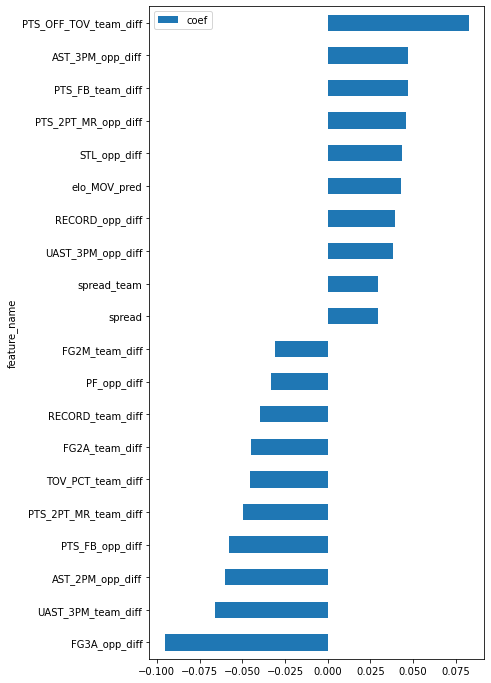

In [59]:
view_model_coefs(best_lr.named_steps['logreg'], X_train)

### SGD

In [228]:
sgd_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(loss='log',
                               max_iter=10000,
                                     random_state=23))])

params = {
    'sgd__alpha': np.logspace(-6,1,500),
}

sgd_cv = GridSearchCV(sgd_pipe, param_grid=params, scoring='roc_auc', cv=tscv, n_jobs=-1)


sgd_cv.fit(X_train, y_train)

best_sgd_log = sgd_cv.best_estimator_
print("best_sgd:", best_sgd_log)


print("train_acc:", best_sgd_log.score(X_train, y_train))
print("test_acc:", best_sgd_log.score(X_test, y_test))

best_sgd: Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.035082471442397886, loss='log',
                               max_iter=10000, random_state=23))])
train_acc: 0.5405201508834624
test_acc: 0.5025028441410694


,feature_name,coef
32,UAST_3PM_team_diff,-0.056544
38,FG3A_opp_diff,-0.051832
57,PTS_FB_opp_diff,-0.051284
25,PTS_2PT_MR_team_diff,-0.033872
48,PF_opp_diff,-0.028689
3,RECORD_team_diff,-0.027043
5,FG2A_team_diff,-0.024882
4,FG2M_team_diff,-0.022985
59,PTS_PAINT_opp_diff,-0.022671
30,UAST_2PM_team_diff,-0.022258


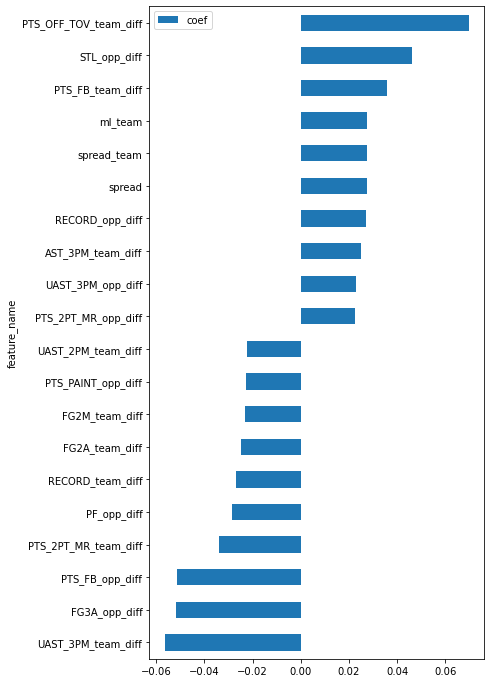

In [156]:
view_model_coefs(best_sgd_log.named_steps['sgd'], X_train)

In [79]:
svc_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', LinearSVC(loss='hinge',
                               max_iter=100000,
                                     random_state=23))])



params = {
    'svc__C': np.logspace(-6,1,100)
}

svc_cv = GridSearchCV(svc_pipe, param_grid=params, scoring='roc_auc', cv=tscv, n_jobs=-1, verbose=1)


svc_cv.fit(X_train, y_train)

best_svc = svc_cv.best_estimator_
print("best_svc:", best_svc)


print("train_score:", best_svc.score(X_train, y_train))
print("test_score:", best_svc.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.1min finished


best_svc: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.009111627561154887, loss='hinge',
                           max_iter=100000, random_state=23))])
train_score: 0.5389716100853683
test_score: 0.5073947667804323


In [84]:
best_svc.fit(X_train, y_train)
best_svc.predict(X_test)

array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
sgd_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(loss='hinge',
                               max_iter=50000,
                                     random_state=23))])

params = {
    'sgd__alpha': np.logspace(-8,-1,100),
    'sgd__penalty':['l1', 'l2']
}

sgd_cv = GridSearchCV(sgd_pipe, param_grid=params, scoring='roc_auc', cv=tscv, n_jobs=-1, verbose=1)


sgd_cv.fit(X_train, y_train)

best_sgd_hinge = sgd_cv.best_estimator_
print("best_sgd_hinge:", best_sgd_hinge)


print("train_score:", best_sgd_hinge.score(X_train, y_train))
print("test_score:", best_sgd_hinge.score(X_test, y_test))

In [83]:
sgd_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(loss='modified_huber',
                               max_iter=10000,
                                     random_state=23))])

params = {
    'sgd__alpha': np.logspace(-6,1,500)
}

sgd_cv = GridSearchCV(sgd_pipe, param_grid=params, scoring='roc_auc', cv=tscv, n_jobs=-1, verbose=1)


sgd_cv.fit(X_train, y_train)

best_sgd_huber = sgd_cv.best_estimator_
print("best_sgd:", best_sgd_huber)


print("train_score:", best_sgd_huber.score(X_train, y_train))
print("test_score:", best_sgd_huber.score(X_test, y_test))

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  7.4min finished


best_sgd: Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.2957616658993257, loss='modified_huber',
                               max_iter=10000, random_state=23))])
train_score: 0.5373436569386539
test_score: 0.5073947667804323


In [81]:
### Light Gradient Boost
from sklearn import model_selection
model_selection

<module 'sklearn.model_selection' from 'C:\\Users\\Jordan Nishimura\\Anaconda3\\lib\\site-packages\\sklearn\\model_selection\\__init__.py'>

In [57]:
lgbr = lgb.LGBMClassifier()

search_spaces = {'min_child_weight':Integer(1,16),
              'subsample': Real(0.6, 1),
              'max_depth': Integer(3, 20),
              'reg_lambda': Real(1, 20),
              'reg_alpha': Real(0, 5),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'num_leaves':Integer(2, 20000),
                'feature_fraction':Real(0.01, 1)
                }
    
    
lgbr_bs = BayesSearchCV(lgb.LGBMClassifier(objective='binary', 
                                           subsample_freq=1), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1, n_iter=400)


lgbr_bs.fit(X_train, y_train)

best_lgbr = lgbr_bs.best_estimator_

print("best_lgbr:", best_lgbr)

print(best_lgbr.score(X_test, y_test))



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


[LightGBM] [Warning] feature_fraction is set=0.5713468531287551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5713468531287551
best_lgbr: LGBMClassifier(feature_fraction=0.5713468531287551, max_depth=3,
               min_child_weight=5, num_leaves=16994, objective='binary',
               reg_alpha=3.871642630856302, reg_lambda=18.917205320358356,
               subsample=0.6064680836703954, subsample_freq=1)
0.509556313993174


In [162]:
best_lgbc = lgb.LGBMClassifier(feature_fraction=0.18084090028537358, max_depth=10,
               min_child_weight=16, num_leaves=1962, objective='binary',
               reg_alpha=0.0992744863701456, reg_lambda=14.31731273276015,
               subsample=0.8667133316882505, subsample_freq=1)

best_lgbc = lgb.LGBMClassifier(feature_fraction=0.18084090028537358, max_depth=4,
               min_child_weight=16, num_leaves=19979, objective='binary',
               reg_alpha=0.0992744863701456, reg_lambda=14.31731273276015,
               subsample=0.8667133316882505, subsample_freq=1)

best_lgbc.fit(X_train, y_train)

print(best_lgbc.score(X_train, y_train))
print(best_lgbc.score(X_test, y_test))

[LightGBM] [Warning] feature_fraction is set=0.18084090028537358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18084090028537358
0.659072455461623
0.5015927189988624


In [68]:
len(np.arange(2, 1024, 5))

205

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    9.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished


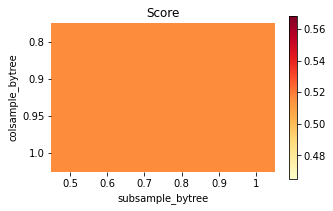

LGBMClassifier(colsample_bytree=0.8, feature_fraction=0.5713468531287551,
               gamma=0.0, max_depth=8, min_child_weight=5, num_leaves=32,
               objective='binary', reg_alpha=0.12742749857031335, reg_lambda=3,
               subsample=0.6064680836703954, subsample_bytree=0.5,
               subsample_freq=1) 0.5167235494880547


In [77]:
lgbc = lgb.LGBMClassifier(feature_fraction=1.0, max_depth=15, min_child_weight=1,
               num_leaves=25, objective='binary', reg_alpha=1, reg_lambda=3,
               subsample=0.6, subsample_freq=1)


lgbc = lgb.LGBMClassifier(colsample_bytree=0.8, feature_fraction=0.5713468531287551,
               gamma=0.0, max_depth=8, min_child_weight=5, num_leaves=32,
               objective='binary', reg_alpha=0.12742749857031335, reg_lambda=3,
               subsample=0.6064680836703954, subsample_bytree=0.5,
               subsample_freq=1)

grid = {
#      "max_depth"        : np.arange(8, 12),
#     'num_leaves': np.arange(2, 100, 1)
#   "min_child_weight" : np.arange(1, 31, 1),
#  "gamma"            : np.linspace(0, 3, 10),
 "colsample_bytree" : [0.8, 0.9, 0.95, 1.0],
"subsample_bytree":[0.5, 0.6, 0.7, 0.8, 0.9, 1],
# "reg_alpha":np.logspace(-3,1, 20),
# "reg_lambda":np.arange(0, 20, 1),
#     'learning_rate':[0.05, 0.1, 0.15, 0.2]
}   
 

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(lgbc, param_grid,
                                                            X_train, y_train, 
                                                            X_test, y_test,
                                                            metric=accuracy_score)

print(best_model, best_score)


LGBoost or XGBoost


,feature_name,coef
66,rest_diff,8
85,spread,11
50,PLUS_MINUS_opp_diff,11
55,PIE_opp_diff,15
53,E_NET_RATING_opp_diff,15
51,E_OFF_RATING_opp_diff,16
22,E_NET_RATING_team_diff,16
52,E_DEF_RATING_opp_diff,16
75,EFG_PCT_team_diff,18
19,PLUS_MINUS_team_diff,19


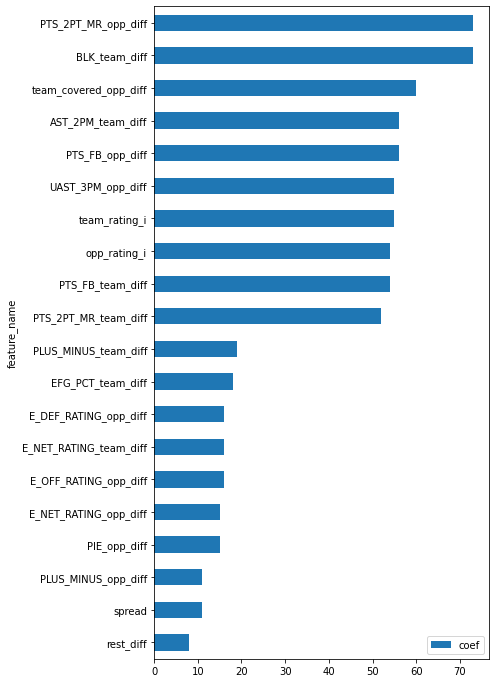

In [75]:
best_lgbm = lgb.LGBMClassifier(colsample_bytree=0.8, feature_fraction=0.5713468531287551,
               gamma=0.0, max_depth=8, min_child_weight=5, num_leaves=32,
               objective='binary', reg_alpha=0.12742749857031335, reg_lambda=3,
               subsample=0.6064680836703954, subsample_bytree=0.5,
               subsample_freq=1)

best_lgbm.fit(X_train, y_train)
view_model_coefs(best_lgbm, X_train)

In [88]:
best_lgbc = lgb.LGBMClassifier(feature_fraction=1.0, learning_rate=0.15, max_depth=15,
               min_child_weight=1, num_leaves=25, objective='binary',
               reg_alpha=1.2915496650148828, reg_lambda=3, subsample=0.6,
               subsample_freq=1)

test_model_at_threshold(df_ewm_19_diffs, best_lgbc, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
best threshold for testset 1: 0.533
num_games_bet at threshold: 751
win percetange at threshold: 0.5565912117177098
test1_acc: 0.5418326693227091
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
test2_acc: 0.5116988809766022
win_percentage at  0.533 : 0.5263157894736842 ...Games Bet: 703
win_percentage at 0.5489900000000001: 0.5261261261261261 ...Games Bet: 555


,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
0,22000073,MIL vs. CHI,-14.5,126,96,30,1,0.307438,0.764293,0.271572,0,0,100.0,NaN,NaN
2,22000082,PHI vs. CHA,-10.0,127,112,15,1,0.704533,0.390870,0.656832,1,1,NaN,NaN,NaN
3,22000083,ATL vs. CLE,-5.5,91,96,-5,0,0.429416,0.794754,0.317331,0,1,NaN,NaN,NaN
4,22000085,DET vs. BOS,8.0,120,122,-2,1,0.654842,0.512597,0.571123,1,1,NaN,NaN,NaN
5,22000086,BKN vs. WAS,-7.5,122,123,-1,0,0.275526,0.395281,0.440122,0,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,42000113,BOS vs. BKN,7.0,125,119,6,1,0.572240,0.311336,0.630452,1,1,NaN,NaN,NaN
973,42000133,ATL vs. NYK,-4.5,105,94,11,1,0.484197,0.321664,0.581267,1,1,NaN,NaN,NaN
978,42000164,POR vs. DEN,-4.5,115,95,20,1,0.604950,0.502759,0.551095,1,1,NaN,NaN,NaN
979,42000114,BOS vs. BKN,9.0,126,141,-15,0,0.547497,0.351949,0.597774,1,0,NaN,NaN,NaN


LGBoost or XGBoost


,feature_name,coef
50,PLUS_MINUS_opp_diff,2
66,rest_diff,5
34,RECORD_opp_diff,6
53,E_NET_RATING_opp_diff,7
55,PIE_opp_diff,8
22,E_NET_RATING_team_diff,10
70,DREB_PCT_opp_diff,10
69,DREB_PCT_team_diff,11
72,REB_PCT_opp_diff,11
19,PLUS_MINUS_team_diff,12


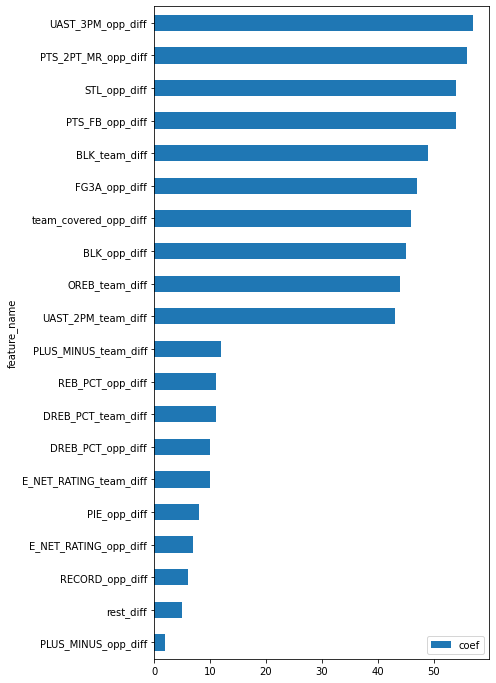

In [101]:
view_model_coefs(best_lgbc, X_train)

### XGB

In [66]:
y_train.isnull().sum()

0

In [68]:
xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.4028067280889247, colsample_bynode=1,
              colsample_bytree=0.8830571030659531, eval_metric='auc',
              gamma=1e-09, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3276608798181443,
              max_delta_step=3, max_depth=5, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, random_state=23, reg_alpha=0.5725260910878867,
              reg_lambda=1,
              scale_pos_weight=0.023349356235903874, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)


search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(1, 10),
        'max_depth': Integer(3, 20),
        'max_delta_step': Integer(1, 20),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-6, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-6, 1.0, 'log-uniform'),
        'gamma': Real(1e-6, 3, 'log-uniform'),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')
    }


xgbc_bs = BayesSearchCV(xgbc, search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1, n_iter=300)

xgbc_bs.fit(X_train, y_train)

best_xgbc = xgbc_bs.best_estimator_

print("best_lgbr:", best_xgbc)


print("xgbc train_acc:", best_xgbc.score(X_train, y_train))
print("xgbc train_acc:", best_xgbc.score(X_test, y_test))


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


best_lgbr: XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.06807554502661296, colsample_bynode=1,
              colsample_bytree=0.6332161435306184, eval_metric='auc',
              gamma=0.01952743832654878, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1.0, max_delta_step=18,
              max_depth=20, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, random_state=23,
              reg_alpha=3.997128370396773e-06, reg_lambda=1e-06,
              scale_pos_weight=3.6188743802336383, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)
xgbc train_acc: 1.0
xgbc train_acc: 0.50671875


In [83]:
np.linspace(0.3, 0.9, 7)

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  1.5min remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.3s finished


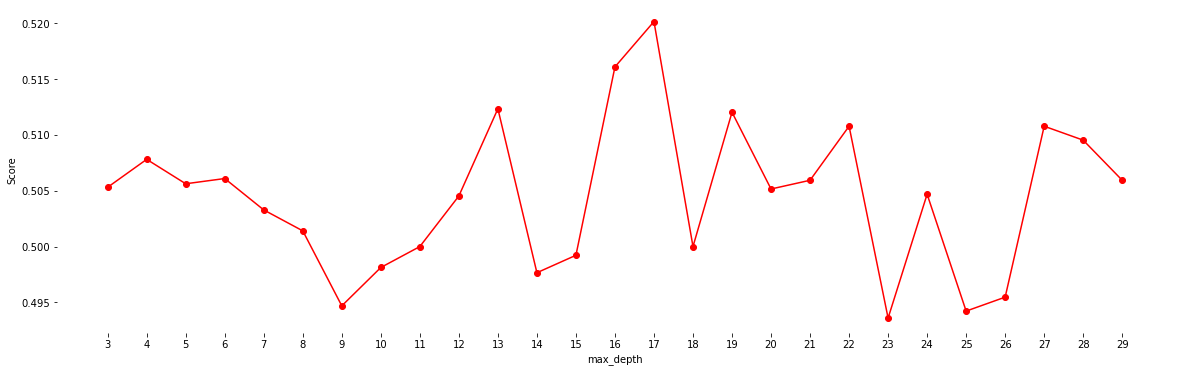

best_model: XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.06807554502661296, colsample_bynode=1,
              colsample_bytree=0.5, eval_metric='auc',
              gamma=0.01952743832654878, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1.0, max_delta_step=18,
              max_depth=17, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, random_state=23,
              reg_alpha=1.2689610031679234e-05, reg_lambda=1e-05,
              scale_pos_weight=3.6188743802336383, subsample=0.9,
              tree_method='approx', validate_parameters=1, verbosity=None)
train_score: 1.0
test_score: 0.52015625


In [102]:
best_xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.06807554502661296, colsample_bynode=1,
              colsample_bytree=0.5, eval_metric='auc',
              gamma=0.01952743832654878, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1.0, max_delta_step=18,
              max_depth=17, min_child_weight=2, missing=np.nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, random_state=23,
              reg_alpha=1.2689610031679234e-05, reg_lambda=1e-05,
              scale_pos_weight=3.6188743802336383, subsample=0.9,
              tree_method='approx', validate_parameters=1, verbosity=None)

grid = {
    'max_depth':np.arange(3, 30),
#     'min_child_weight':np.arange(1, 20),
#     'reg_alpha':np.logspace(-8, 1, 30),
#     'reg_lambda':np.logspace(-8, 1, 50),
#     'subsample':np.linspace(0.3, 0.9, 7),
#     'colsample_bytree':np.linspace(0.3, 0.9, 7)
       }

param_grid = ParameterGrid(grid)


best_model, best_score, all_models, all_scores = pf.bestFit(best_xgbc, param_grid,
                                                            X_train, y_train, 
                                                            X_test, y_test,
                                                            metric=accuracy_score)
print("best_model:", best_model)
print("train_score:", best_model.score(X_train, y_train))

print("test_score:", best_score)

# best_xgbc.fit(X_train, y_train)
# print("xgb train acc:", best_xgbc.score(X_train, y_train))
# print("xgb test acc:", best_xgbc.score(X_test, y_test))


In [88]:
best_xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.06807554502661296, colsample_bynode=1,
              colsample_bytree=0.5, eval_metric='auc',
              gamma=0.01952743832654878, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1.0, max_delta_step=18,
              max_depth=17, min_child_weight=2, missing=np.nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, random_state=23,
              reg_alpha=1.2689610031679234e-05, reg_lambda=1e-05,
              scale_pos_weight=3.6188743802336383, subsample=0.9,
              tree_method='approx', validate_parameters=1, verbosity=None)

xgb_cross_val = np.mean(cross_val_score(best_xgbc, X_train, y_train, cv=tscv))
print("train_cross_val:", xgb_cross_val)
best_xgbc.fit(X_train, y_train)

print(best_xgbc.score(X_train, y_train))
print(best_xgbc.)
best_xgbc.predict(X_test)

array([0, 1, 1, ..., 0, 1, 1])

In [91]:
best_xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.4028067280889247, colsample_bynode=1,
              colsample_bytree=0.8830571030659531, eval_metric='auc',
              gamma=1e-09, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3276608798181443,
              max_delta_step=3, max_depth=3, min_child_weight=9, missing=np.nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.5725260910878867,
              reg_lambda=43.182721933403094,
              scale_pos_weight=0.023349356235903874, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

test_model_at_threshold(df_ewm_19_diffs, best_xgbc, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)

best threshold for testset 1: 0.514
num_games_bet at threshold: 7
win percetange at threshold: 0.8571428571428571
test1_acc: 0.5
test2_acc: 0.5
win_percentage at  0.514 : nan ...Games Bet: 0
win_percentage at 0.52942: nan ...Games Bet: 0


,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size


LGBoost or XGBoost


,feature_name,coef
46,BLK_opp_diff,0.004638
28,PTS_PAINT_team_diff,0.005661
83,opp_rating_i,0.006552
43,REB_opp_diff,0.006904
75,EFG_PCT_team_diff,0.007292
24,PIE_team_diff,0.007648
84,elo_MOV_pred,0.007651
72,REB_PCT_opp_diff,0.007687
54,POSS_opp_diff,0.008055
36,FG2A_opp_diff,0.008065


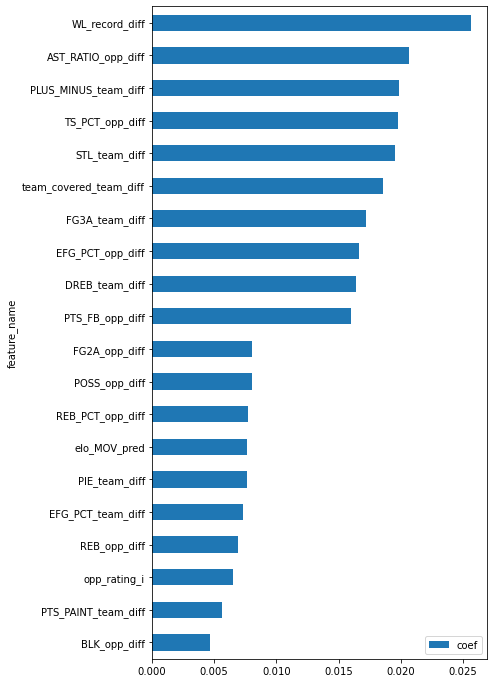

In [72]:
view_model_coefs(best_xgbc, X_train)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 31.0min finished


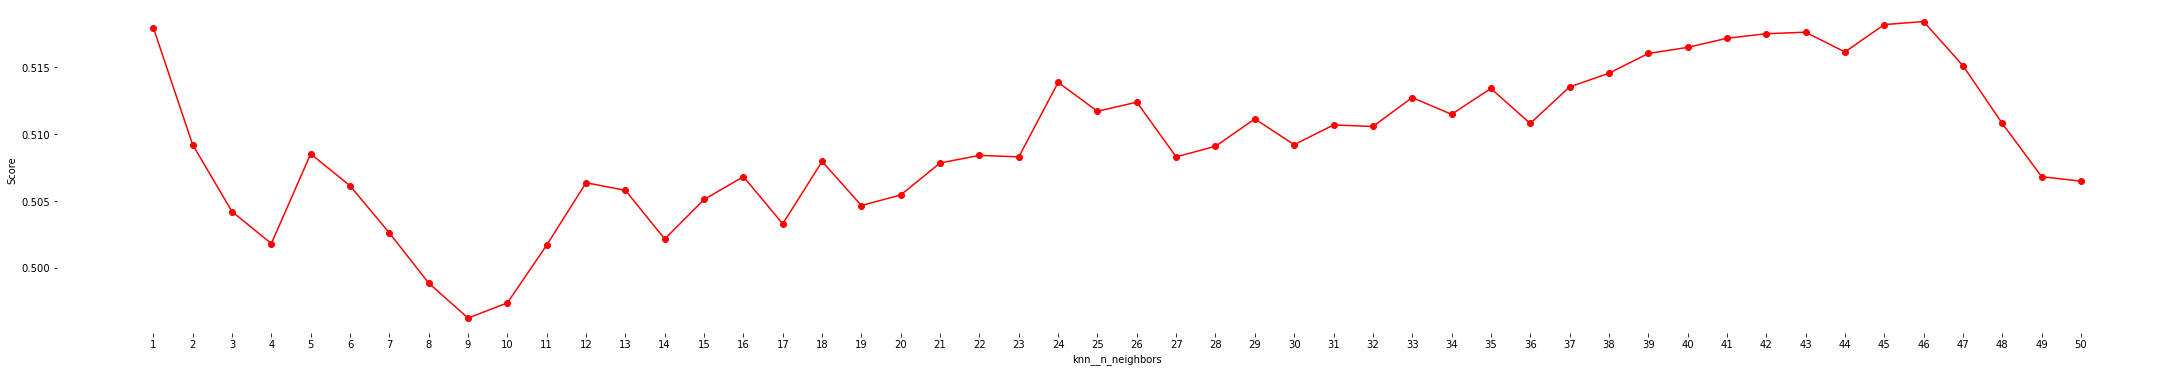

0.5602144133412745
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=46))]) 0.5184300341296928


In [61]:
knn_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier())]) 

knn_pipe.get_params().keys()

grid = {
     "knn__n_neighbors": np.arange(1, 51),
}   
 

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(knn_pipe, param_grid,
                                                            X_train, y_train, 
                                                            X_test, y_test,
                                                            metric=accuracy_score)


print(best_model.score(X_train, y_train))

print(best_model, best_score)


best_knn = best_model



-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.9s finished


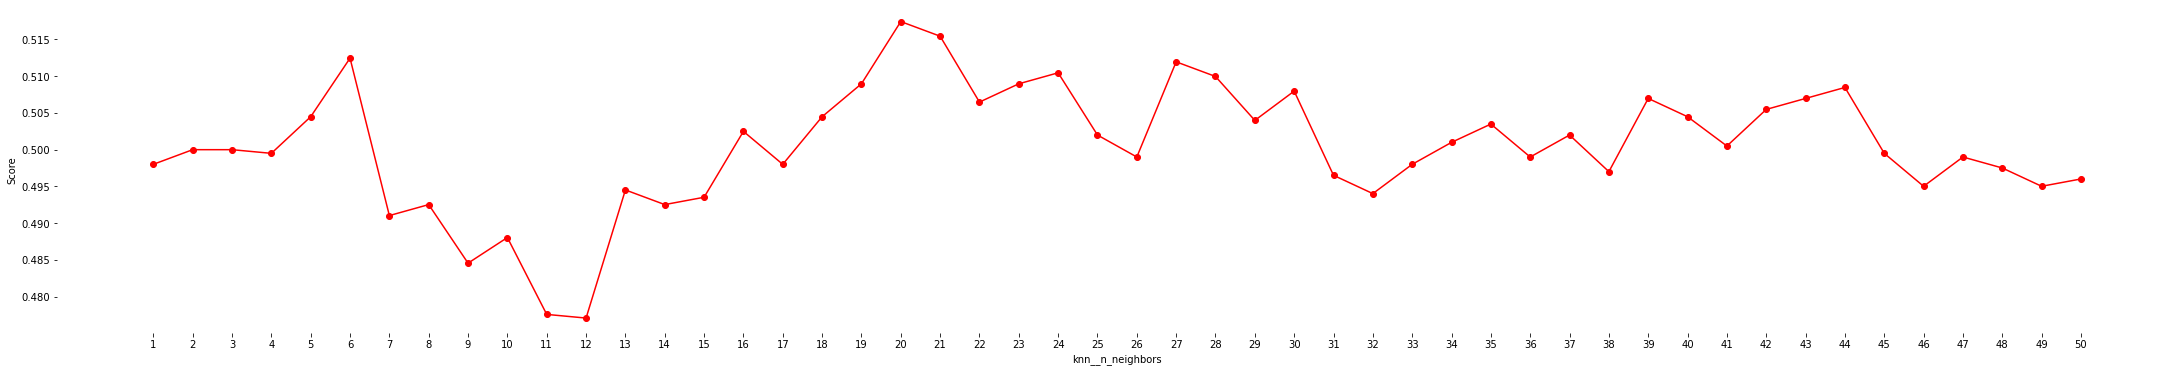

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=20))]) 0.5174302788844621
best threshold for testset 1: 0.813
num_games_bet at threshold: 1
win percetange at threshold: 1.0
test1_acc: 0.5174302788844621
test2_acc: 0.5249237029501526
win_percentage at  0.813 : 1.0 ...Games Bet: 1
win_percentage at 0.83739: 1.0 ...Games Bet: 1


,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
48,22000130,GSW vs. LAC,6.5,115,105,10,1,0.85,0.15,0.85,1,1,NaN,NaN,NaN


In [102]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier())]) 

knn_pipe.get_params().keys()

grid = {
     "knn__n_neighbors": np.arange(1, 51),
}   
 

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(knn_pipe, param_grid,
                                                            X_train, y_train, 
                                                            X_test1, y_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)


best_knn = best_model

test_model_at_threshold(df_ewm_19_diffs, best_knn, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)


In [92]:
np.logspace(-5, -1, 17)

array([1.00000000e-05, 1.77827941e-05, 3.16227766e-05, 5.62341325e-05,
       1.00000000e-04, 1.77827941e-04, 3.16227766e-04, 5.62341325e-04,
       1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01])

In [115]:
df_ewm_19_diffs.loc[X_train1.index]

0.5223804679552391

In [74]:
rf = RandomForestClassifier(max_depth=14, max_features='auto', random_state=23)


params = {
         "max_depth":np.arange(3, 18),
      "min_samples_split":np.linspace(0.05, 0.2, 5),
     "min_samples_leaf":np.linspace(0.05, 0.2, 5),
#     "max_features":np.linspace(0.01, 1, 100),
#         "ccp_alpha":np.linspace(0, 1, 21)
    }


rf_bs = GridSearchCV(rf, param_grid=params,
                        cv=tscv, verbose=1, n_jobs=-1)

rf_bs.fit(X_train, y_train)

best_rf = rf_bs.best_estimator_

print("best_rf:", best_rf)


print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))


Fitting 5 folds for each of 375 candidates, totalling 1875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 1875 out of 1875 | elapsed: 13.1min finished


best_rf: RandomForestClassifier(max_depth=6, min_samples_leaf=0.05,
                       min_samples_split=0.2, random_state=23)
rf train_acc: 0.5413142743696645
rf test_acc: 0.5062571103526735


In [94]:
best_rf = RandomForestClassifier(max_depth=14, max_features=0.34, random_state=23)
best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

rf train_acc: 0.9936151947633867
rf test_acc: 0.50140625


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  4.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.1s finished


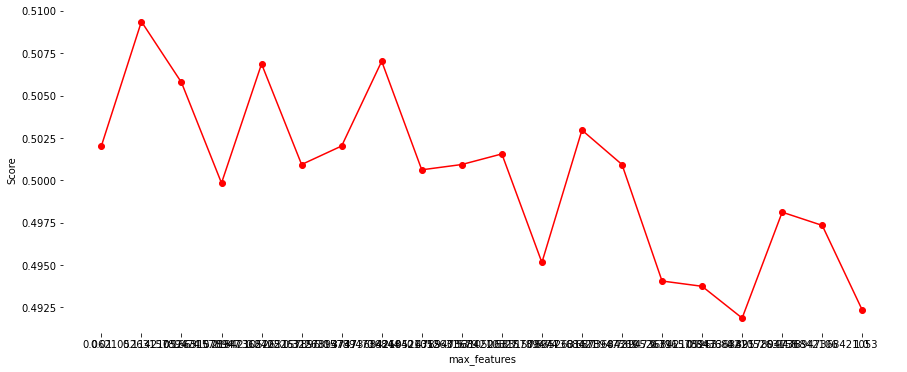

RandomForestClassifier(max_depth=17, max_features=0.06210526315789474,
                       random_state=23) 0.509375


In [86]:
rf = RandomForestClassifier(max_depth=17, random_state=23)
    
    
grid = {
#      "max_depth":np.arange(3, 22, 1),
#   "min_samples_split":np.linspace(0.01, 0.5, 10),
#  "min_samples_leaf":np.linspace(0.01, 0.5, 10),
"max_features":np.linspace(0.01, 1.0, 20)
#     "ccp_alpha":np.logspace(-3, 1, 30)
} 

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(rf, param_grid,
                                                            X_train, y_train, 
                                                            X_test, y_test,
                                                            metric=accuracy_score)

print(best_model, best_score)

best_rf = best_model



In [66]:
best_rf = RandomForestClassifier(max_depth=17, max_features=0.06210526315789474,
                       random_state=23)


best_rf.fit(X_train, y_train)

print(cross_val_score(best_rf, X_train, y_train, cv=tscv))

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

[0.50257566 0.51738571 0.50901481 0.50579524 0.49549259]
rf train_acc: 0.9989269234896448
rf test_acc: 0.509375


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.1min remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished


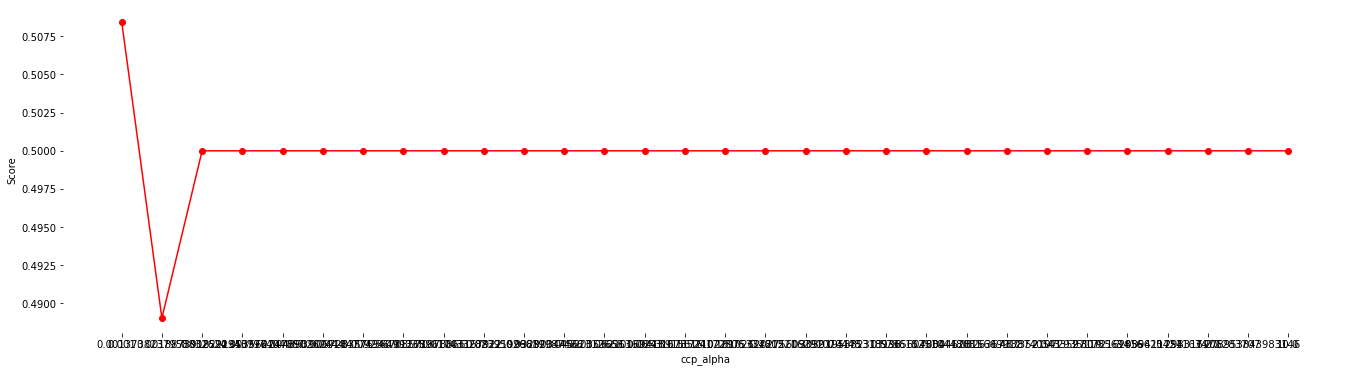

RandomForestClassifier(ccp_alpha=0.001, max_depth=3,
                       max_features=0.8957894736842106,
                       min_samples_leaf=0.2822222222222222,
                       min_samples_split=0.01, random_state=23) 0.5084661354581673


In [115]:
rf = RandomForestClassifier(ccp_alpha=0.001, max_depth=3,
                       max_features=0.8957894736842106,
                       min_samples_leaf=0.2822222222222222,
                       min_samples_split=0.01, random_state=23)
    
    
grid = {
     "max_depth":np.arange(3, 22, 1),
#   "min_samples_split":np.linspace(0.01, 0.5, 10),
#  "min_samples_leaf":np.linspace(0.01, 0.5, 10),
# "max_features":np.linspace(0.01, 1.0, 20)
#     "ccp_alpha":np.logspace(-3, 1, 30)
} 

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(rf, param_grid,
                                                            X_train, y_train, 
                                                            X_test1, y_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)

best_rf = best_model



In [117]:
best_rf =RandomForestClassifier(ccp_alpha=0.00, max_depth=3,
                       max_features=0.8957894736842106,
                       min_samples_leaf=0.2822222222222222,
                       min_samples_split=0.01, random_state=23)

test_model_at_threshold(df_ewm_19_diffs, best_rf, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)

best threshold for testset 1: 0.514
num_games_bet at threshold: 85
win percetange at threshold: 0.5294117647058824
test1_acc: 0.5064741035856574
test2_acc: 0.4745676500508647
win_percentage at  0.514 : 0.49206349206349204 ...Games Bet: 126
win_percentage at 0.52942: nan ...Games Bet: 0


,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size


## Stacked Classifier

In [65]:
best_sgd_log = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.0582815458123084, loss='log',
                               max_iter=10000, random_state=23))])


best_svc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.009111627561154887, loss='hinge',
                           max_iter=100000, random_state=23))])



best_lgbc = lgb.LGBMClassifier(colsample_bytree=0.8, feature_fraction=0.5713468531287551,
               gamma=0.0, max_depth=8, min_child_weight=5, num_leaves=32,
               objective='binary', reg_alpha=0.12742749857031335, reg_lambda=3,
               subsample=0.6064680836703954, subsample_bytree=0.5,
               subsample_freq=1)


best_rf = RandomForestClassifier(max_depth=6, min_samples_leaf=0.05,
                       min_samples_split=0.2, random_state=23)


best_knn = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=46))])



estimators = [('sgd_log', best_sgd_log),
              ('svc', best_svc), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf train_acc:", stacked_clf.score(X_test, y_test))

stacked clf train_acc: 0.529045066507842
stacked clf train_acc: 0.5064846416382253


In [80]:
stacked_clf

StackingClassifier(estimators=([('sgd_log',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('sgd',
                                                  SGDClassifier(alpha=0.0582815458123084,
                                                                loss='log',
                                                                max_iter=10000,
                                                                random_state=23))])),
                                ('sgd_hinge',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('sgd',
                                                  SGDClassifier(alpha=0.002009233002565046,
                                                                max_iter=20000,
                                                                random_state=23))])),
                                ('xgbc',
       

In [119]:
best_lr = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.0005689866029018293, max_iter=1000))])

best_sgd_log = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.06579332246575675, loss='log',
                               max_iter=10000, random_state=23))])


best_sgd_huber = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=1.0476157527896641, loss='modified_huber',
                               max_iter=10000, random_state=23))])


best_lgbc = lgb.LGBMClassifier(feature_fraction=0.18084090028537358, max_depth=10,
               min_child_weight=16, num_leaves=1962, objective='binary',
               reg_alpha=0.0992744863701456, reg_lambda=14.31731273276015,
               subsample=0.8667133316882505, subsample_freq=1)


best_xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7140320930892107,
              gamma=7.068171775625379, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=13, min_child_weight=5, missing=np.nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=23, reg_alpha=10,
              reg_lambda=0.03627210312422547, scale_pos_weight=1, subsample=1,
                tree_method='exact', validate_parameters=1,
              verbosity=None)


best_rf = RandomForestClassifier(max_depth=3, max_features=0.06210526315789474,
                       min_samples_leaf=0.01,
                       min_samples_split=0.2822222222222222, random_state=23)


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=20))])

best_mlp = Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=1e-06,
                               hidden_layer_sizes=(128, 128, 64, 1),
                               learning_rate_init=0.0019306977288832496,
                               max_iter=5000, random_state=23))])

estimators = [('sgd_huber', best_sgd_huber), ('lr', best_lr),
              ('sgd_log', best_sgd_log), ('lgbc', best_lgbc), 
              ('xgbc', best_xgbc),
             ('knn', best_knn), ('mlp', best_mlp)]



stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


test_model_at_threshold(df_ewm_19_diffs, stacked_clf, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)

best threshold for testset 1: 0.53
num_games_bet at threshold: 196
win percetange at threshold: 0.5510204081632653
test1_acc: 0.499003984063745
test2_acc: 0.4832146490335707
win_percentage at  0.53 : 0.584070796460177 ...Games Bet: 113
win_percentage at 0.5459: 1.0 ...Games Bet: 8


,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
5,22000086,BKN vs. WAS,-7.5,122,123,-1,0,0.441128,0.533720,0.453704,0,1,NaN,NaN,NaN
7,22000088,MIN vs. DEN,8.5,109,124,-15,0,0.449777,0.561853,0.443962,0,1,NaN,NaN,NaN
43,22000125,NYK vs. OKC,-3.0,89,101,-12,0,0.447287,0.555039,0.446124,0,1,NaN,NaN,NaN
50,22000132,SAC vs. TOR,1.0,123,144,-21,0,0.445299,0.552876,0.446211,0,1,NaN,NaN,NaN
73,22000157,PHI vs. MIA,-8.5,137,134,3,0,0.442200,0.542409,0.449895,0,1,NaN,NaN,NaN
274,22000385,CHI vs. NOP,2.5,129,116,13,1,0.548014,0.454697,0.546658,1,1,NaN,NaN,NaN
790,22000920,NYK vs. PHX,2.5,110,118,-8,0,0.456318,0.555326,0.450496,0,1,NaN,NaN,NaN
938,22001063,MIN vs. BOS,-5.0,108,124,-16,0,0.452473,0.547993,0.452240,0,1,NaN,NaN,NaN


In [123]:
stacked_clf.fit(X_train, y_train)

stacked_probs1 = stacked_clf.predict_proba(X_test1)

stacked_bets = create_betting_df(df_ewm_19_diffs, stacked_probs1, test_idx1)

stacked_bets

,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
0,21900073,CHI vs. DET,-4.0,112,106,6,1,0.509733,0.493834,0.507949,1,1,100.0,NaN,NaN
1,21900075,SAC vs. UTA,4.5,102,101,1,1,0.505855,0.495265,0.505295,1,1,NaN,NaN,NaN
2,21900077,OKC vs. NOP,-2.5,115,104,11,1,0.487312,0.514012,0.486650,0,0,NaN,NaN,NaN
3,21900078,DET vs. BKN,4.0,113,109,4,1,0.496337,0.496487,0.499925,0,0,NaN,NaN,NaN
4,21900082,MIL vs. TOR,-6.5,115,105,10,1,0.531727,0.468942,0.531392,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,41900402,LAL vs. MIA,-11.0,124,114,10,0,0.499152,0.505584,0.496784,0,1,NaN,NaN,NaN
1000,41900403,MIA vs. LAL,9.5,115,104,11,1,0.496501,0.502745,0.496878,0,0,NaN,NaN,NaN
1001,41900404,MIA vs. LAL,7.5,96,102,-6,1,0.476617,0.519083,0.478767,0,0,NaN,NaN,NaN
1002,41900405,LAL vs. MIA,-7.5,108,111,-3,0,0.521177,0.474012,0.523583,1,0,NaN,NaN,NaN


In [66]:
X_train1, X_test, y_train1, y_test, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoff_17)

X_test1, y_test1, test_idx1 = X_test.loc[:cutoff_19], y_test.loc[:cutoff_19], X_test.loc[:cutoff_19].index
X_test2, y_test2, test_idx2 = X_test.loc[cutoff_19+1:], y_test.loc[cutoff_19+1:], X_test.loc[cutoff_19+1:].index


X_train2 = pd.concat([X_train1, X_test1])
y_train2 = pd.concat([y_train1, y_test1])

In [67]:
print(X_train1.shape, X_test1.shape, X_test2.shape)

(25185, 86) (4816, 86) (3974, 86)


In [71]:
df_ewm_19_diffs.loc[test_idx2]

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,SCORE_team,point_diff_team,WL_team,ml_team,spread_team,team_covered_team_diff,RECORD_team_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,E_DEF_RATING_team_diff,E_NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,team_covered_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,E_NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,WL_record_diff,ATS_record_diff,rest_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
49204,2019-20,22019,1610612765,DET,Detroit Pistons,21900073,2019-11-01,DET @ CHI,0,106,-6,0,2.550000,4.0,0.201973,0.201973,0.264218,-1.639789,0.645699,-9.631413,0.182364,1.164587,-2.278577,3.231325,0.952748,2.572367,-3.113135,-0.462944,7.915948,-1.907865,2.647896,1.224879,2.698913,-0.220649,2.870968,0.140143,0.025899,5.929574,-7.314815,-5.916217,-5.176723,0.585773,-0.525970,1.890577,-0.822666,-0.201973,-0.201973,6.249689,8.274865,-2.547557,-5.936925,-3.433689,-4.982101,-6.223755,-8.353789,-14.577544,3.126859,5.924031,-3.832336,-4.881297,0.756270,1.423018,-1.224879,-0.220649,2.698913,-2.870968,0.731557,-0.025899,6.890259,-0.393055,11.812044,5.875290,5.207223,1.042465,-2.860589,0.468609,0.200000,0.200000,0.0,0.001488,-0.128983,0.128983,-0.001488,0.084819,-0.084819,0.082519,-0.000482,0.079249,0.013194,2.506931,2.894056,7.332364,-3.672165,0.586243,1453.832404,1445.184670,1324.299675,1332.947409,4.63
49205,2019-20,22019,1610612741,CHI,Chicago Bulls,21900073,2019-11-01,CHI vs. DET,1,112,6,1,1.555556,-4.0,-0.201973,-0.201973,-0.264218,1.639789,-0.645699,9.631413,-0.182364,-1.164587,2.278577,-3.231325,-0.952748,-2.572367,3.113135,0.462944,-7.915948,1.907865,-2.647896,-1.224879,-2.698913,0.220649,-2.870968,-0.140143,-0.025899,-5.929574,7.314815,5.916217,5.176723,-0.585773,0.525970,-1.890577,0.822666,0.201973,0.201973,-6.249689,-8.274865,2.547557,5.936925,3.433689,4.982101,6.223755,8.353789,14.577544,-3.126859,-5.924031,3.832336,4.881297,-0.756270,-1.423018,1.224879,0.220649,-2.698913,2.870968,-0.731557,0.025899,-6.890259,0.393055,-11.812044,-5.875290,-5.207223,-1.042465,2.860589,-0.468609,-0.200000,-0.200000,0.0,-0.001488,0.128983,-0.128983,0.001488,-0.084819,0.084819,-0.082519,0.000482,-0.079249,-0.013194,-2.506931,-2.894056,-7.332364,3.672165,0.413757,1324.299675,1332.947409,1453.832404,1445.184670,-4.63
49208,2019-20,22019,1610612762,UTA,Utah Jazz,21900075,2019-11-01,UTA @ SAC,0,101,-1,0,1.500000,-4.5,0.441992,0.821982,1.211692,-3.989207,-0.883348,-7.452443,2.924153,3.013211,-6.418915,8.066055,1.647139,0.357940,0.365290,-1.054919,1.295793,2.391566,2.697492,25.170667,4.951515,-20.218698,25.154192,-1.394764,0.187074,-1.212742,1.664843,1.446729,4.278113,0.692535,0.139166,-0.095040,-0.568533,-0.441992,-0.821982,-5.833460,0.410271,-4.164269,-6.486435,1.686552,3.378990,-2.954311,-3.941149,-6.895460,-7.456130,-1.852165,0.111230,0.005910,2.808185,-22.473175,-25.170667,-20.218698,4.951515,-25.154192,-1.645112,-0.187074,1.61

In [115]:
best_lr = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.0027825594022071257, max_iter=1000))])

select_bets_lr = test_model_at_threshold(df_ewm_19_diffs, best_lr, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)

best threshold for testset 1: 0.582
num_games_bet at threshold: 268
win percetange at threshold: 0.5671641791044776
test1_acc: 0.5085132890365448
test2_acc: 0.5070457976849522
win_percentage at  0.582 : 0.5566037735849056 ...Games Bet: 106
win_percentage at 0.59946: 0.5609756097560976 ...Games Bet: 41


In [118]:
best_svc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.009111627561154887, loss='hinge',
                           max_iter=100000, random_state=23))])


select_bets_lgbc = test_model_at_threshold(df_ewm_19_diffs, best_svc, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)

best threshold for testset 1: 0.757
num_games_bet at threshold: 193
win percetange at threshold: 0.5906735751295337
test1_acc: 0.5105897009966778
test2_acc: 0.5010065425264217
win_percentage at  0.757 : 0.5529411764705883 ...Games Bet: 85
win_percentage at 0.77971: 0.5208333333333334 ...Games Bet: 48


In [94]:
best_lgbc = lgb.LGBMClassifier(feature_fraction=0.18084090028537358, max_depth=10,
               min_child_weight=16, num_leaves=1962, objective='binary',
               reg_alpha=0.0992744863701456, reg_lambda=14.31731273276015,
               subsample=0.8667133316882505, subsample_freq=1)

select_bets_lgbc = test_model_at_threshold(df_ewm_19_diffs, best_lgbc, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)

[LightGBM] [Warning] feature_fraction is set=0.18084090028537358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18084090028537358
best threshold for testset 1: 0.692
num_games_bet at threshold: 14
win percetange at threshold: 0.6428571428571429
test1_acc: 0.5087209302325582
[LightGBM] [Warning] feature_fraction is set=0.18084090028537358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18084090028537358
test2_acc: 0.49622546552591845
win_percentage at  0.692 : 0.6 ...Games Bet: 5
win_percentage at 0.71276: 0.5 ...Games Bet: 2


In [119]:
best_rf = RandomForestClassifier(max_depth=6, min_samples_leaf=0.05,
                       min_samples_split=0.2, random_state=23)


best_rf.fit(X_train, y_train)


print(best_rf.score(X_test1, y_test1))

test_model_at_threshold(df_ewm_19_diffs, best_rf, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)

0.5174418604651163
best threshold for testset 1: 0.518
num_games_bet at threshold: 356
win percetange at threshold: 0.5842696629213483
test1_acc: 0.5174418604651163
test2_acc: 0.4889280322093608
win_percentage at  0.518 : 0.48633879781420764 ...Games Bet: 183
win_percentage at 0.53354: nan ...Games Bet: 0


,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size


In [120]:
best_knn = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=46))])


best_knn.fit(X_train, y_train)


print(best_knn.score(X_test1, y_test1))

test_model_at_threshold(df_ewm_19_diffs, best_knn, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)


0.5110049833887044
best threshold for testset 1: 0.609
num_games_bet at threshold: 276
win percetange at threshold: 0.532608695652174
test1_acc: 0.5110049833887044
test2_acc: 0.515601409159537
win_percentage at  0.609 : 0.5477178423236515 ...Games Bet: 241
win_percentage at 0.62727: 0.5606060606060606 ...Games Bet: 198


,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
1,21900075,SAC vs. UTA,4.5,102,101,1,1,0.652174,0.347826,0.652174,1,1,NaN,NaN,NaN
3,21900078,DET vs. BKN,4.0,113,109,4,1,0.369565,0.652174,0.358696,0,0,NaN,NaN,NaN
11,21900090,LAC vs. UTA,-5.0,105,94,11,1,0.369565,0.673913,0.347826,0,0,NaN,NaN,NaN
20,21900100,CHI vs. LAL,7.0,112,118,-6,1,0.695652,0.347826,0.673913,1,1,NaN,NaN,NaN
30,21900110,UTA vs. PHI,-3.0,106,104,2,0,0.673913,0.326087,0.673913,1,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,22001063,MIN vs. BOS,-5.0,108,124,-16,0,0.630435,0.369565,0.630435,1,0,NaN,NaN,NaN
1943,22001064,NYK vs. CHA,-6.0,118,109,9,1,0.304348,0.695652,0.304348,0,0,NaN,NaN,NaN
1955,22001077,SAC vs. UTA,11.5,99,121,-22,0,0.369565,0.630435,0.369565,0,1,NaN,NaN,NaN
1960,42000171,LAC vs. DAL,-6.0,103,113,-10,0,0.347826,0.630435,0.358696,0,1,NaN,NaN,NaN


In [72]:
print(stacked_clf.score(X_test1, y_test1))

test_model_at_threshold(df_ewm_19_diffs, stacked_clf, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2)

0.510797342192691
best threshold for testset 1: 0.529
num_games_bet at threshold: 1036
win percetange at threshold: 0.5347490347490348
test1_acc: 0.510797342192691
test2_acc: 0.504026170105687
win_percentage at  0.529 : 0.5500821018062397 ...Games Bet: 609
win_percentage at 0.5448700000000001: 0.5305164319248826 ...Games Bet: 213


,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
5,21900083,GSW vs. CHA,5.5,87,93,-6,0,0.568340,0.436428,0.565956,1,0,NaN,NaN,NaN
7,21900086,MIA vs. HOU,3.0,129,100,29,1,0.366755,0.637602,0.364577,0,0,NaN,NaN,NaN
16,21900095,PHX vs. PHI,0.0,114,109,5,1,0.413866,0.585213,0.414326,0,0,NaN,NaN,NaN
17,21900096,GSW vs. POR,11.5,127,118,9,1,0.578447,0.423263,0.577592,1,1,NaN,NaN,NaN
20,21900100,CHI vs. LAL,7.0,112,118,-6,1,0.548631,0.446296,0.551168,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,22001031,POR vs. HOU,-15.0,140,129,11,0,0.440318,0.563241,0.438539,0,1,NaN,NaN,NaN
1915,22001041,LAL vs. NYK,-2.5,101,99,2,0,0.553088,0.449011,0.552039,1,0,NaN,NaN,NaN
1918,22001043,BKN vs. SAS,-5.0,128,116,12,1,0.552509,0.445259,0.553625,1,1,NaN,NaN,NaN
1919,22001044,CLE vs. BOS,6.0,102,94,8,1,0.448105,0.549964,0.449070,0,0,NaN,NaN,NaN


In [122]:
stacked_probs = stacked_clf.predict_proba(X_test2)

betting_df_stacked = create_betting_df(df_ewm_19_diffs, stacked_probs, test_idx2)



,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
0,21900073,CHI vs. DET,-4.0,112,106,6,1,0.521421,0.474956,0.523232,1,1,100.0,NaN,NaN
1,21900075,SAC vs. UTA,4.5,102,101,1,1,0.517416,0.483386,0.517015,1,1,NaN,NaN,NaN
2,21900077,OKC vs. NOP,-2.5,115,104,11,1,0.482033,0.515827,0.483103,0,0,NaN,NaN,NaN
3,21900078,DET vs. BKN,4.0,113,109,4,1,0.488216,0.506602,0.490807,0,0,NaN,NaN,NaN
4,21900082,MIL vs. TOR,-6.5,115,105,10,1,0.544801,0.458922,0.542939,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982,42000164,POR vs. DEN,-4.5,115,95,20,1,0.478664,0.521226,0.478719,0,0,NaN,NaN,NaN
1983,42000114,BOS vs. BKN,9.0,126,141,-15,0,0.530094,0.471997,0.529049,1,0,NaN,NaN,NaN
1984,42000134,ATL vs. NYK,-5.0,113,96,17,1,0.509536,0.487353,0.511092,1,1,NaN,NaN,NaN
1985,42000154,LAL vs. PHX,-6.5,92,100,-8,0,0.482103,0.517272,0.482416,0,1,NaN,NaN,NaN


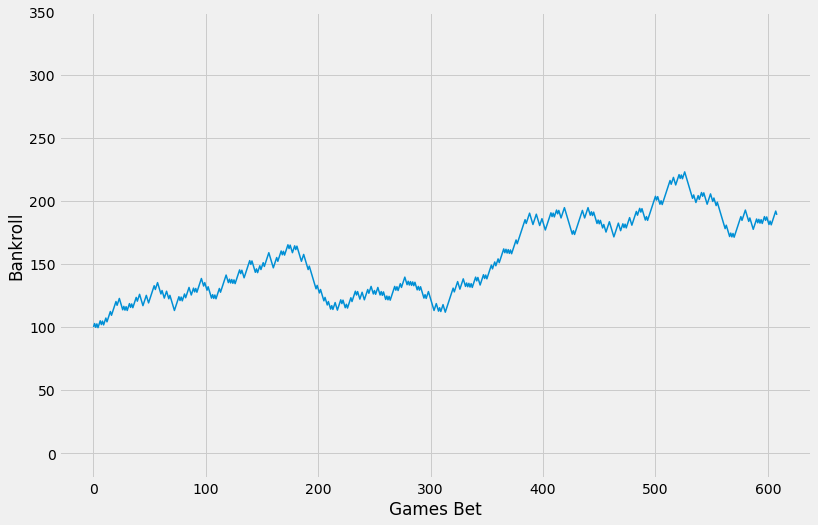

min balance: 99.45454545454547 
max balance: 222.99999999999892 
final balance: 191.63636363636226 
win percentage 55.010000000000005 
profit: 91.63636363636351 risk: 1827.0 
ROI: 5.0200000000000005


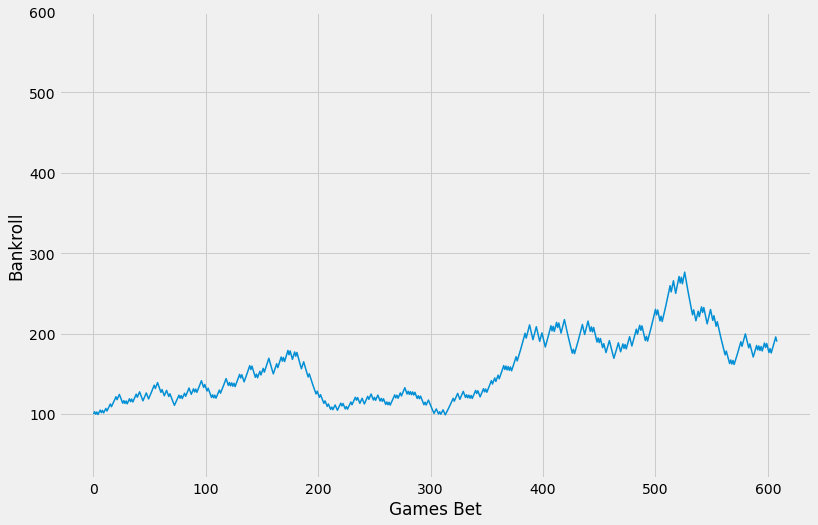

min balance: 98.91925095983876 
max balance: 276.3104877949524 
final balance: 195.06719000680226 
win percentage 55.010000000000005 
profit: 95.06719000680232 risk: 2861.880283213513 
ROI: 3.32


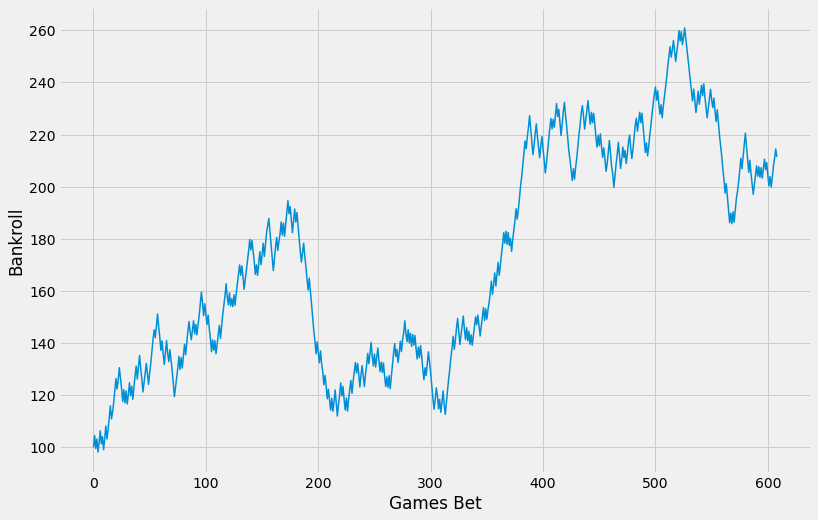

min balance: 98.18181818181819 
max balance: 260.90909090908843 
final balance: 215.0909090909062 
win percentage 55.010000000000005 
profit: 115.09090909090901 risk: 2697.0 
ROI: 4.2700000000000005


,index,GAME_ID,MATCHUP_home,spread_home,team_score_home,team_score_away,point_diff_home,cover_home,prob_home,prob_away,prob_avg,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
0,4,21900082,MIL vs. TOR,-6.5,115,105,10,1,0.544801,0.458922,0.542939,1,1,100.000000,104.545455,5.0
1,5,21900083,GSW vs. CHA,5.5,87,93,-6,0,0.568340,0.436429,0.565955,1,0,104.545455,99.545455,5.0
2,6,21900085,IND vs. CHI,-2.0,108,95,13,1,0.527858,0.467752,0.530053,1,1,99.545455,103.181818,4.0
3,7,21900086,MIA vs. HOU,3.0,129,100,29,1,0.366757,0.637601,0.364578,0,0,103.181818,98.181818,5.0
4,8,21900087,NYK vs. SAC,1.5,92,113,-21,0,0.463993,0.531336,0.466329,0,1,98.181818,101.818182,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,1975,42000163,POR vs. DEN,-4.0,115,120,-5,0,0.456735,0.542343,0.457196,0,1,203.545455,208.090909,5.0
605,1976,42000113,BOS vs. BKN,7.0,125,119,6,1,0.528813,0.469069,0.529872,1,1,208.090909,210.818182,3.0
606,1981,42000143,MEM vs. UTA,5.5,111,121,-10,0,0.464027,0.533378,0.465325,0,1,210.818182,214.454545,4.0
607,1983,42000114,BOS vs. BKN,9.0,126,141,-15,0,0.530094,0.471997,0.529049,1,0,214.454545,211.454545,3.0


In [126]:
select_bets_stacked = betting_df_stacked.loc[~betting_df_stacked['prob_avg'].between(1-0.529, 0.529)]

simulate_bets_1(select_bets_stacked, 3)

simulate_bets_2(select_bets_stacked, 0.03)

simulate_bets_3(select_bets_stacked)


### Custom Loss NN Pytorch

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [100]:
torch_scaler = StandardScaler()

X_train_scaled = torch_scaler.fit_transform(X_train)
X_test_scaled = torch_scaler.transform(X_test)

# X_train2_scaled = torch_scaler.fit_transform(X_train2)
# X_test2_scaled = torch_scaler.transform(X_test2)


class MatchupDataset(Dataset):
    
    def __init__(self, features, targets):
        self.targets = targets
        self.features = features
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        X = self.features[index]
        y = self.targets[index]
        
        return X, y
    
batch_size = 128

training_set1 = MatchupDataset(X_train_scaled, y_train.values)
validation_set1 = MatchupDataset(X_test_scaled, y_test.values)

train_loader1 = DataLoader(training_set1, batch_size = batch_size, shuffle=False)
val_loader1 = DataLoader(validation_set1, batch_size = batch_size, shuffle=False)

# training_set2 = MatchupDataset(X_train2_scaled, y_train2.values)
# validation_set2 = MatchupDataset(X_test2_scaled, y_test2.values)

# train_loader2 = DataLoader(training_set2, batch_size = batch_size, shuffle=False)
# val_loader2 = DataLoader(validation_set2, batch_size = batch_size, shuffle=False)



In [104]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(X_train.shape[1], 256)
#         self.bn1 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(256, 128)
#         self.bn2 = nn.BatchNorm1d(num_features=64)
        self.fc3 = nn.Linear(128, 64)
#         self.bn3 = nn.BatchNorm1d(num_features=32)
        self.fc4 = nn.Linear(64, 16)
        self.fc5 = nn.Linear(16, 1)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.dropout(torch.tanh(self.fc1(x)))
        x = self.dropout(torch.tanh(self.fc2(x)))
        x = self.dropout(torch.tanh(self.fc3(x)))      
        x = self.dropout(torch.tanh(self.fc4(x)))

        x = torch.sigmoid(self.fc5(x))
        return x
        
net = Net() 
print(net)

Net(
  (fc1): Linear(in_features=86, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [105]:
torch.manual_seed(23)

net = Net()

learning_rate = 0.000001
# def my_loss(output, target):
#     residual = (output-target).float()
#     output*
#     return

loss_function = nn.BCELoss()

optimizer = optim.Adam(net.parameters(), lr=learning_rate)

epochs = 1501

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net.train()
    
    for (data, target) in  train_loader1:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        n_correct_preds = (torch.round(outputs)==target).detach().numpy().flatten().astype(int).sum()
        train_correct_preds += n_correct_preds
        train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train.shape[0])
    train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net.eval()
        for batch_idx, (data, target) in enumerate(val_loader1):
            target = target.reshape(-1, 1)
            outputs = net(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
            n_correct_preds = (torch.round(outputs)==target).detach().numpy().flatten().astype(int).sum()
            val_correct_preds += n_correct_preds
            val_total_preds += outputs.shape[0]

        val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test.shape[0])
        
    if e % 5 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.7f}.. ".format(train_loss / X_train.shape[0]),
             "Test Loss: {:.7f}.. ".format(val_loss / X_test.shape[0]),
             "Train Accuracy: {:.4f}..".format(train_accuracies[-1]),
             "Test Accuracy: {:.4f}..".format(val_accuracies[-1]))


Epoch: 1/1501..  Training Loss: 0.0054742..  Test Loss: 0.0054432..  Train Accuracy: 0.4985.. Test Accuracy: 0.5000..
Epoch: 6/1501..  Training Loss: 0.0054619..  Test Loss: 0.0054407..  Train Accuracy: 0.5000.. Test Accuracy: 0.5000..
Epoch: 11/1501..  Training Loss: 0.0054643..  Test Loss: 0.0054384..  Train Accuracy: 0.5020.. Test Accuracy: 0.5000..
Epoch: 16/1501..  Training Loss: 0.0054629..  Test Loss: 0.0054364..  Train Accuracy: 0.5006.. Test Accuracy: 0.5000..
Epoch: 21/1501..  Training Loss: 0.0054574..  Test Loss: 0.0054346..  Train Accuracy: 0.5009.. Test Accuracy: 0.5000..
Epoch: 26/1501..  Training Loss: 0.0054532..  Test Loss: 0.0054329..  Train Accuracy: 0.5051.. Test Accuracy: 0.5000..
Epoch: 31/1501..  Training Loss: 0.0054553..  Test Loss: 0.0054313..  Train Accuracy: 0.5043.. Test Accuracy: 0.5000..
Epoch: 36/1501..  Training Loss: 0.0054550..  Test Loss: 0.0054299..  Train Accuracy: 0.4979.. Test Accuracy: 0.5000..
Epoch: 41/1501..  Training Loss: 0.0054494..  Test

KeyboardInterrupt: 

In [197]:
nn_preds1 = net(torch.tensor(X_test1_scaled).float())
nn_preds2 = net(torch.tensor(X_test2_scaled).float())

preds1 = pd.DataFrame({'prob':nn_preds1.detach().numpy().flatten(),
                     'target':y_test1})

preds1['bet_home'] = preds1['prob'].astype(int)
preds1['bet_won'] = (preds1['bet_home'] == preds1['target']).astype(int)
preds1.loc[~preds1['prob'].between(0.49, 0.51)].mean()

prob        0.493061
target      0.508974
bet_home    0.000000
bet_won     0.491026
dtype: float64

In [154]:
test_outputs = np.array([])

for data, target in val_loader1:
    outputs = net(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    test_outputs = np.concatenate([test_outputs, outputs.detach().numpy().flatten()])

# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
preds = pd.DataFrame({'preds':test_outputs, 'target':point_diff_test1})
# test_outputs.detach().numpy().flatten()

select_bets_nn, bet_thresholds_nn = find_optimal_confidence_thresholds(df_ewm_diffs_19, test_outputs,
                                                                               test_idx1)
simulate_bets(select_bets_nn)


NameError: name 'point_diff_test1' is not defined

In [181]:
bet_thresholds_nn.loc[bet_thresholds_nn['prediction_num']==3]

,index,prediction_num,confidence_thresholds,num_games_bet,win_percentage,expected_profits
36,2146,3,1.47,1584,0.545455,8640
40,2147,3,1.48,1567,0.544990,8396
41,2189,3,1.90,1153,0.554206,8388
44,2145,3,1.46,1602,0.544320,8360
48,2149,3,1.50,1548,0.544574,8160
...,...,...,...,...,...,...
875,2567,3,5.68,15,0.533333,44
876,2568,3,5.69,15,0.533333,44
877,2569,3,5.70,15,0.533333,44
878,2570,3,5.71,15,0.533333,44


In [216]:
print(len(val_loader2) * 32)

X_test2.shape

7008


(6992, 164)

In [217]:
net = Net()

learning_rate = 0.000005
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)

epochs = 160

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net.train()
    
    for (data, target) in  train_loader2:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

#         n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
#         train_correct_preds += n_correct_preds
#         train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train2.shape[0])
#     train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net.eval()
        for batch_idx, (data, target) in enumerate(val_loader2):
            target = target.reshape(-1, 1)
            outputs = net(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
#             n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
#             val_correct_preds += n_correct_preds
#             val_total_preds += outputs.shape[0]

#         val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test2.shape[0])
        
    if e % 10 == 0:
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train2.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test2.shape[0]))


Epoch: 0/160..  Training Loss: 5.806562..  Test Loss: 6.386216.. 
Epoch: 10/160..  Training Loss: 5.221600..  Test Loss: 5.761154.. 
Epoch: 20/160..  Training Loss: 4.836733..  Test Loss: 5.370768.. 
Epoch: 30/160..  Training Loss: 4.779824..  Test Loss: 5.300383.. 
Epoch: 40/160..  Training Loss: 4.698755..  Test Loss: 5.242830.. 
Epoch: 50/160..  Training Loss: 4.632791..  Test Loss: 5.191969.. 
Epoch: 60/160..  Training Loss: 4.594651..  Test Loss: 5.150405.. 
Epoch: 70/160..  Training Loss: 4.547083..  Test Loss: 5.117874.. 
Epoch: 80/160..  Training Loss: 4.509670..  Test Loss: 5.097426.. 
Epoch: 90/160..  Training Loss: 4.496081..  Test Loss: 5.084373.. 
Epoch: 100/160..  Training Loss: 4.461044..  Test Loss: 5.077161.. 
Epoch: 110/160..  Training Loss: 4.447700..  Test Loss: 5.073328.. 
Epoch: 120/160..  Training Loss: 4.429356..  Test Loss: 5.069898.. 
Epoch: 130/160..  Training Loss: 4.428498..  Test Loss: 5.068149.. 
Epoch: 140/160..  Training Loss: 4.414505..  Test Loss: 5.0

In [218]:
preds_train2 = net(torch.tensor(X_train2_scaled).float()).detach().numpy()
preds_test2 = net(torch.tensor(X_test2_scaled).float()).detach().numpy()

mae_diff_train: 9.165797430162671 mae_diff_test: 9.885434602811353
Train Betting Overall Accuracy: 0.5407401524777636
Test Betting Overall Accuracy: 0.5099648300117233


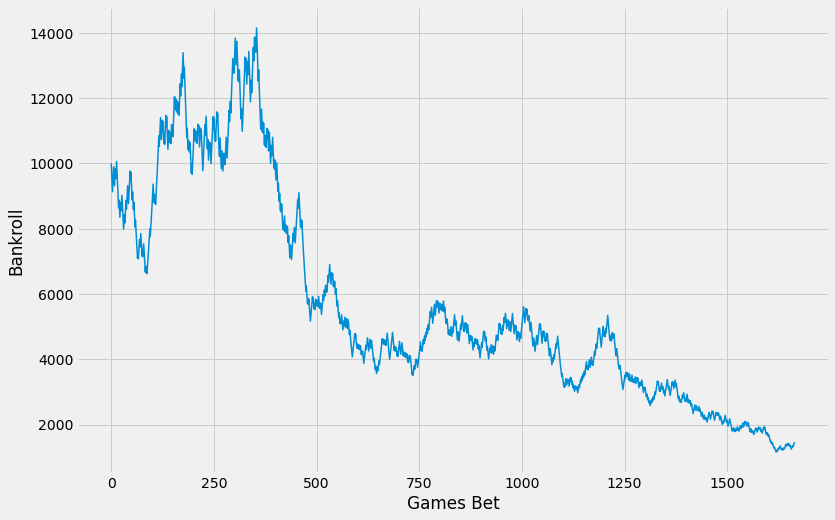

min balance: 1155.4883030792748 
max balance: 14142.122593625492 
final balance: 1502.3531346025138 
win percentage 51.11


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,confidence_pred1,confidence_pred2,confidence_pred3,bankroll_i,bankroll_n,bet_size,bet_won
0,0,21700077,NOP vs. CLE,2.5,2.150000,1.740741,123,101,22,1,-6.313794,6.844114,-6.578954,0,0,0,-3.813794,-4.344114,-4.078954,10000.000000,9700.000000,300.000000,0
1,1,21700080,MEM vs. HOU,-2.0,1.800000,2.050000,103,89,14,1,-1.591051,1.323781,-1.457416,0,0,0,-3.591051,-3.323781,-3.457416,9700.000000,9409.000000,291.000000,0
2,2,21700081,DAL vs. PHI,1.0,2.000000,1.833333,110,112,-2,0,-0.577614,-3.686752,1.554569,1,1,1,0.422386,4.686752,2.554569,9409.000000,9126.730000,282.270000,0
3,4,21700083,POR vs. PHX,-12.0,1.133333,6.000000,114,107,7,0,9.790244,-9.372024,9.581134,0,0,0,-2.209756,-2.627976,-2.418866,9126.730000,9375.640818,273.801900,1
4,6,21700086,IND vs. SAS,6.5,3.110000,1.357143,97,94,3,1,-3.780788,2.469774,-3.125281,1,1,1,2.719212,4.030226,3.374719,9375.640818,9631.340113,281.269225,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660,3485,41900304,MIA vs. BOS,3.5,2.380000,1.588235,112,109,3,1,-1.046955,-0.073273,-0.486841,1,1,1,2.453045,3.573273,3.013159,1313.237380,1349.052944,39.397121,1
1661,3489,41900306,MIA vs. BOS,3.0,2.200000,1.714286,125,113,12,1,-1.202846,0.949766,-1.076306,1,1,1,1.797154,2.050234,1.923694,1349.052944,1385.845297,40.471588,1
1662,3491,41900402,LAL vs. MIA,-11.0,1.157480,4.930000,124,114,10,0,7.784851,-8.259991,8.022421,0,0,0,-3.215149,-2.740009,-2.977579,1385.845297,1423.641078,41.575359,1
1663,3492,41900403,MIA vs. LAL,9.5,4.300000,1.210526,115,104,11,1,-7.161108,6.006633,-6.583870,1,1,1,2.338892,3.493367,2.916130,1423.641078,1462.467653,42.709232,1


In [220]:
mae_diff_train = mean_absolute_error(point_diff_train2, preds_train2)
mae_diff_test = mean_absolute_error(point_diff_test2, preds_test2)

print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_diff_test)


bets_train = create_betting_df(df_19, preds_train2, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, preds_test2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())


bets = create_betting_df(df_19, preds_test2, test_idx2, 3)
select_bets = bets.loc[abs(bets['confidence_pred3']) > 1.47]    
simulate_bets(select_bets)


In [224]:
df_19.loc[test_idx2]

,SEASON_YEAR_x,SEASON_ID_x,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE_x,MATCHUP_x,HOME_GAME_x,SCORE_team_x,point_diff_team_x,WL_team_x,ml_team_x,spread_team_x,team_covered_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,E_DEF_RATING_team_x,E_NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,team_covered_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,E_DEF_RATING_opp_x,E_NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,WL_record_x,ATS_record_x,rest_x,OREB_PCT_team_x,OREB_PCT_opp_x,DREB_PCT_team_x,DREB_PCT_opp_x,REB_PCT_team_x,REB_PCT_opp_x,TS_PCT_team_x,TS_PCT_opp_x,EFG_PCT_team_x,EFG_PCT_opp_x,AST_RATIO_team_x,AST_RATIO_opp_x,TOV_PCT_team_x,TOV_PCT_opp_x,team_elo_pred_x,team_rating_i_x,team_rating_n_x,opp_rating_i_x,opp_rating_n_x,elo_MOV_pred_x,WL_team_y,team_covered_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,E_DEF_RATING_team_y,E_NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,team_covered_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,E_DEF_RATING_opp_y,E_NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,WL_record_y,ATS_record_y,rest_y,OREB_PCT_team_y,OREB_PCT_opp_y,DREB_PCT_team_y,DREB_PCT_opp_y,REB_PCT_team_y,REB_PCT_opp_y,TS_PCT_team_y,TS_PCT_opp_y,EFG_PCT_team_y,EFG_PCT_opp_y,AST_RATIO_team_y,AST_RATIO_opp_y,TOV_PCT_team_y,TOV_PCT_opp_y,covered
25627,2017-18,22017,1610612739,CLE,Cleveland Cavaliers,21700077,2017-10-28,CLE @ NOP,0,101,-22,0,1.740741,-2.5,0.178018,0.558008,28.831604,52.752582,10.590584,29.996386,18.234256,23.556323,9.175820,35.419184,44.595004,21.743279,5.015824,4.928182,16.198799,15.960904,107.669214,0.026690,108.027887,107.869261,0.134207,98.647603,0.509433,12.714366,7.781519,18.355205,43.926864,12.130717,15.700886,8.330786,1.639789,0.821982,0.441992,24.952700,51.782521,14.489951,36.765940,14.267271,18.082709,9.439794,31.011135,40.450929,25.003883,8.094576,3.575590,12.778247,22.177578,107.642524,-0.026690,107.869261,108.027887,-0.134207,98.207590,0.490567,11.288198,7.643672,17.887549,37.325364,12.034016,12.138458,12.016263,1.811922,0.600000,0.200000,3.0,0.228328,0.210433,0.789567,0.771672,0.524364,0.475636,0.612234,0.581684,0.540399,0.527255,22.041365,25.460235,14.818791,11.692794,0.640724,1642.277699,1621.509052,1472.780374,1493.549021,6.05,1,0.620009,0.441992,27.862885,53.072550,11.100266,31.151010,18.730287,25.365657,9.919562,36.167493,46.087055,21.282875,7.154013,5.894655,17.225660,23.879783,107.756856,-2.206344,104.786919,106.145557,-1.336661,103.664990,0.480218,5.915167,8.965007,14.658470,48.773021,11.160851,15.702034,8.895631,1.580450,0.379991,0.558008,29.516740,59.496300,10.333545,28.364851,19.929086,25.359771,11.140509,34.456790,45.597299,23.388171,7.142414,6.652048,15.619936,22.474152,109.963200,2.206344,106.145557,104.786919,1.336661,104.185417,0.519782,11.779053,14.018827,17.028107,46.812434,14.766233,13.910723,8.246123,1.551391,0.400000,0

In [227]:
test = df_19.loc[test_idx2]
(abs(test['spread_team_x'] + test['point_diff_team_x'])).mean()

9.767019450800916

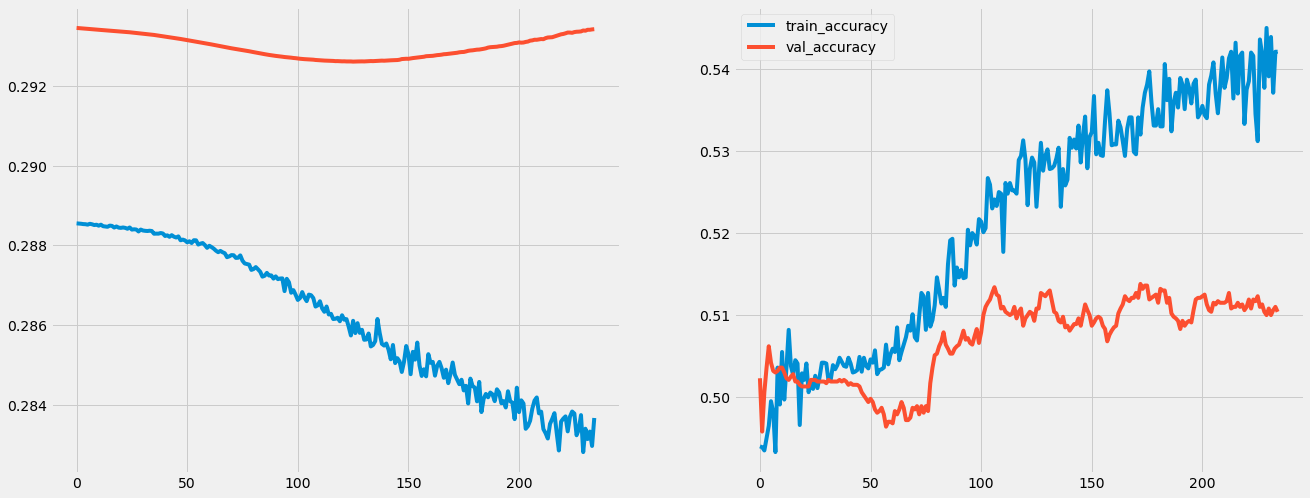

In [492]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].plot(train_losses, label='train_loss')
axs[0].plot(val_losses, label='val_loss')

axs[1].plot(train_accuracies, label='train_accuracy')
axs[1].plot(val_accuracies, label='val_accuracy')
plt.legend()
plt.show()

In [482]:
net2 =Net()

learning_rate = 0.000001
def my_loss(output, target):
    residual = (output-target).float()
    choicelist = [torch.where(output<=0, residual**2, 3*residual**2), torch.where(output<=0, 3*residual**2, residual**2)]
    loss = torch.where(target<=0, choicelist[0], choicelist[1])
#     loss = -torch.log(torch.sigmoid((torch.sign(target) * torch.clamp((output - target), -20, 20))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net2.parameters(), lr=learning_rate, weight_decay=0)

epochs = 500

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net2.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net2(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
        train_correct_preds += n_correct_preds
        train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train_ewm_19.shape[0])
    train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net2.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target.reshape(-1, 1)
            outputs = net2(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
            n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
            val_correct_preds += n_correct_preds
            val_total_preds += outputs.shape[0]

        val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test_ewm_19.shape[0])
        
    if e % 20 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train_ewm_19.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test_ewm_19.shape[0]),
             "Training Accuracy {:.3f}..".format(train_accuracies[-1]), 
             "Validation Accuracy {:.3f}..".format(val_accuracies[-1]))


Epoch: 1/500..  Training Loss: 4.285663..  Test Loss: 4.377806..  Training Accuracy 0.510.. Validation Accuracy 0.503..
Epoch: 21/500..  Training Loss: 4.285192..  Test Loss: 4.377680..  Training Accuracy 0.512.. Validation Accuracy 0.501..
Epoch: 41/500..  Training Loss: 4.284325..  Test Loss: 4.377541..  Training Accuracy 0.509.. Validation Accuracy 0.503..
Epoch: 61/500..  Training Loss: 4.282853..  Test Loss: 4.377401..  Training Accuracy 0.517.. Validation Accuracy 0.502..
Epoch: 81/500..  Training Loss: 4.284114..  Test Loss: 4.377295..  Training Accuracy 0.510.. Validation Accuracy 0.501..
Epoch: 101/500..  Training Loss: 4.283797..  Test Loss: 4.377206..  Training Accuracy 0.514.. Validation Accuracy 0.501..
Epoch: 121/500..  Training Loss: 4.282302..  Test Loss: 4.377129..  Training Accuracy 0.512.. Validation Accuracy 0.500..
Epoch: 141/500..  Training Loss: 4.282051..  Test Loss: 4.377056..  Training Accuracy 0.514.. Validation Accuracy 0.501..
Epoch: 161/500..  Training Los

KeyboardInterrupt: 

In [493]:
train_outputs = np.array([])
train_outputs2 = np.array([])
train_targets = np.array([])
for data, target in train_loader:
    outputs = net(data.float())
    outputs2 = net2(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    train_outputs = np.concatenate([train_outputs, outputs.detach().numpy().flatten()])
    train_outputs2 = np.concatenate([train_outputs2, outputs2.detach().numpy().flatten()])

    train_targets = np.concatenate([train_targets, target.detach().numpy().flatten()])
# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
train_preds = pd.DataFrame({'preds':train_outputs, 'preds2':train_outputs2, 'target':train_targets})
# test_outputs.detach().numpy().flatten()
train_preds

,preds,preds2,target
0,-1.569377,-0.411728,4.5
1,2.848549,-0.101551,-1.5
2,-0.019031,-0.067838,3.5
3,2.170247,-0.185665,-19.5
4,-3.343860,-0.671299,-10.0
...,...,...,...
11767,0.601759,0.044105,28.5
11768,0.989692,0.048848,-13.5
11769,1.633067,0.119707,-20.5
11770,2.350058,0.031689,12.0


In [481]:
train_preds['preds2'].describe()

count    11772.000000
mean        -0.051085
std          0.081908
min         -0.467047
25%         -0.102110
50%         -0.046459
75%          0.006428
max          0.208395
Name: preds2, dtype: float64

In [465]:
y_pred = net(data.float())

preds_df = pd.DataFrame({"y_true":target.detach().numpy().flatten(), "y_pred":y_pred.detach().numpy().flatten()})
preds_df

,y_true,y_pred
0,-1.0,-0.362796
1,2.5,0.376909
2,-11.5,0.066797
3,3.0,0.101686
4,-9.5,0.647189
5,13.0,0.814767
6,8.5,0.058365
7,23.0,0.676957
8,-14.0,0.330269
9,20.0,1.236707


In [494]:
test_outputs = np.array([])
test_outputs2 = np.array([])

for data, target in val_loader:
    outputs = net(data.float())
    outputs2 = net2(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    test_outputs = np.concatenate([test_outputs, outputs.detach().numpy().flatten()])
    test_outputs2 = np.concatenate([test_outputs2, outputs2.detach().numpy().flatten()])

# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
preds = pd.DataFrame({'preds':test_outputs, 'preds2':test_outputs2, 'target':spread_point_diff_test_ewm_19})
# test_outputs.detach().numpy().flatten()

In [495]:
preds['bet_won'] = (np.sign(preds['preds']) == np.sign(preds['target'])).astype(int)
print(preds['bet_won'].mean())
preds['pred_probs'] = 1 / (1 + np.exp(-preds['preds']/10))
preds['pred_scaled'] = preds['preds']*10
preds['bet_home'] = (preds['preds'] > 0).astype(int)

0.5010620220900595


In [496]:
preds


,preds,preds2,target,bet_won,pred_probs,pred_scaled,bet_home
11772,3.245110,0.129812,-10.5,0,0.580423,32.451100,1
11773,-5.352964,-0.005315,31.5,0,0.369282,-53.529644,0
11774,-0.912930,-0.088472,-3.5,1,0.477193,-9.129300,0
11775,2.345120,0.156321,13.5,1,0.558361,23.451197,1
11776,-0.504047,-0.434542,12.0,0,0.487401,-5.040472,0
...,...,...,...,...,...,...,...
16475,3.186399,0.029901,-1.0,0,0.578993,31.863995,1
16476,1.176630,0.109124,20.5,1,0.529382,11.766295,1
16477,0.970830,0.048862,1.5,1,0.524252,9.708300,1
16478,1.041771,0.114306,-10.5,0,0.526021,10.417712,1


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.32
num_games_bet: 1623
win percetange at threshold: 0.5465187923598275


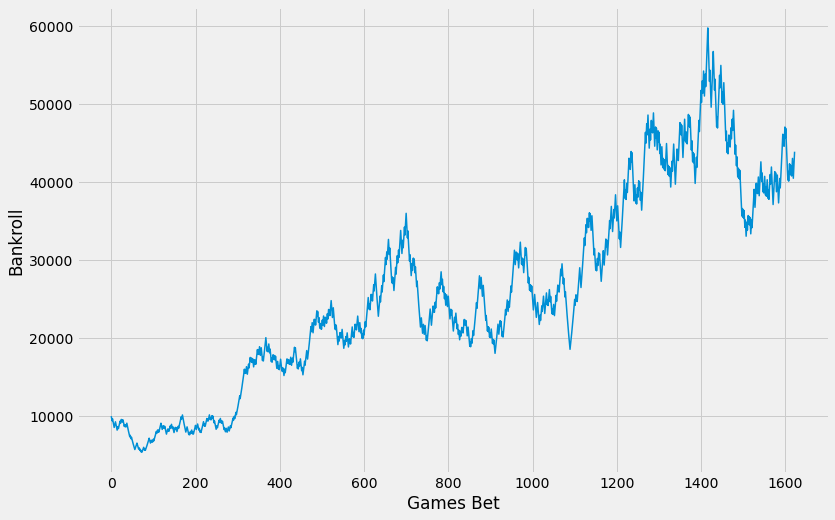

min balance: 5394.227702928191 
max balance: 59766.325969626225 
final balance: 42585.72589427221 
win percentage 54.65


,index,GAME_DATE,spread,point_diff_team,confidence_preds,home_cover,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
0,11772,2016-11-04 00:00:00,3.5,-14.0,3.245110,0.0,1,0,10000.000000,9700.000000,300.000000
1,11773,2016-11-04 00:00:00,11.5,20.0,-5.352964,1.0,0,0,9700.000000,9409.000000,291.000000
2,11775,2016-11-05 00:00:00,-3.5,17.0,2.345120,1.0,1,1,9409.000000,9665.609091,282.270000
3,11778,2016-11-05 00:00:00,-4.5,-24.0,2.687921,0.0,1,0,9665.609091,9375.640818,289.968273
4,11785,2016-11-07 00:00:00,-5.5,12.0,-6.921419,1.0,0,0,9375.640818,9094.371594,281.269225
...,...,...,...,...,...,...,...,...,...,...,...
1618,16446,2020-09-04 00:00:00,-5.5,-15.0,3.672901,0.0,1,0,41750.656697,40498.136996,1252.519701
1619,16448,2020-09-05 00:00:00,-9.0,-9.0,-4.396315,0.0,0,1,40498.136996,41602.631641,1214.944110
1620,16450,2020-09-06 00:00:00,-6.0,8.0,2.686229,1.0,1,1,41602.631641,42737.248868,1248.078949
1621,16464,2020-09-17 00:00:00,-3.0,-5.0,-4.081581,0.0,0,1,42737.248868,43902.810200,1282.117466


In [497]:
select_bets_nn, best_thresholds_nn = find_optimal_confidence_thresholds(test_outputs, test_indices)
simulate_bets(select_bets_nn)

In [459]:
(select_bets_nn['confidence_preds']>0).mean()

0.0

### Train NN on Full Data



In [397]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

df_2020 = add_elo_ratings(df_2020, final_elo_2020)

features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]
progress:: 603it [00:00, 830.59it/s]


In [400]:
spread_point_diff_2020 = df_2020['point_diff_team'] + df_2020['home_spread_mode']
spread_point_diff_2020

0      15.5
1     -13.5
2       5.0
3     -10.5
4      -6.5
       ... 
598    26.5
599     1.0
600    -5.0
601     3.5
602   -18.5
Length: 603, dtype: float64

In [401]:
features_ewm_19.shape, spread_point_diff_ewm_19.shape, features_2020.shape
full_data = pd.concat([features_ewm_19, features_2020])
spread_point_diff_full = pd.concat([spread_point_diff_ewm_19, spread_point_diff_2020])

full_data.shape, spread_point_diff_full.shape

((17083, 90), (17083,))

In [410]:
x = pd.concat([full_data, spread_point_diff_full], axis=1)
x.rename(columns={0:'target'}, inplace=True)
x.to_csv("../data/clean_data_ewm_19.csv", index=False)

In [498]:
nn_scaler = StandardScaler()

full_dataset = MatchupDataset(nn_scaler.fit_transform(full_data), spread_point_diff_full.values)

full_data_loader = DataLoader(full_dataset, batch_size = batch_size, shuffle=False) 

net_full = Net()

learning_rate = 0.00001
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net_full.parameters(), lr=learning_rate, weight_decay=0)

epochs = 131

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in tqdm(range(epochs), desc='progress'):
    train_loss = 0
    train_correct_preds = 0
    train_total_preds = 0

    net_full.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = torch.clamp(net_full(data.float()), -10, 10)
        loss = my_loss(outputs, target.float())
        loss.backward()

        optimizer.step()

progress: 100%|██████████████████████████████████████████████████████████████████████| 131/131 [01:36<00:00,  1.35it/s]


### Test Model on current Season

In [279]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


In [280]:
df_2020

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,SCORE_team,point_diff_team,WL_team,MIN_team,home_spread_mode,WL_record_diff,ATS_record_diff,RECORD_team_diff,team_covered_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,OFF_RATING_team_diff,E_DEF_RATING_team_diff,DEF_RATING_team_diff,E_NET_RATING_team_diff,NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,TEAM_SCORE_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,DEF_RATING_opp_diff,E_NET_RATING_opp_diff,NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff,rest_diff
0,2020-21,22020,1610612749,MIL,Milwaukee Bucks,22000073,2021-01-01,MIL vs. CHI,1,126,30,1,240,-14.5,0.000000,0.000000,-0.066177,-0.044199,1.011550,2.233474,3.260629,3.390149,-6.676491,-8.486240,4.910820,1.387561,6.298381,-1.032478,2.213475,0.701155,-3.405069,-0.850578,5.128495,14.763473,11.435291,9.455071,-4.956033,-4.520647,16.381920,13.957916,-4.426900,0.065356,3.118678,10.509316,1.884960,-1.071622,-1.486508,2.897829,0.254035,2.824400,-9.634978,0.066177,-2.987693,-3.582184,0.887256,2.669410,-6.321360,-7.097702,-0.751825,-0.842495,-1.594320,-4.252912,-3.906571,1.080877,-0.489023,-7.030158,-9.634978,-14.763473,-4.956033,-4.520647,11.435291,9.455071,-16.381920,-13.957916,-4.158287,-0.065356,-1.039242,-2.276550,-2.787722,-4.953945,-3.752216,1.008718,-0.458475,1.079558,0.087657,-0.020046,0.020046,-0.087657,0.043574,-0.043574,0.002207,-0.034683,0.030188,-0.013070,0.055526,-3.103493,-2.691784,0.135976,1.0
1,2020-21,22020,1610612754,IND,Indiana Pacers,22000080,2021-01-02,IND vs. NYK,1,102,-4,0,240,-9.5,0.400000,0.400000,0.362653,0.362653,8.412029,2.926742,0.491954,1.743449,-1.692413,-2.246441,-2.108740,-2.153671,-4.262411,4.948182,3.933677,0.045445,-3.606334,0.583307,16.607507,13.628922,13.953637,13.038807,1.916451,0.881366,11.997407,12.175244,3.179214,0.087311,0.287783,14.191815,6.727797,16.776294,4.646236,3.368001,0.183488,0.688457,2.978584,-0.362653,-1.219775,5.708456,1.145125,-11.783497,1.982760,2.612976,-2.749994,-3.153403,-5.903397,-0.515567,0.003468,-1.125027,3.509145,-1.064370,2.978584,-13.628922,1.916451,0.881366,13.953637,13.038807,-11.997407,-12.175244,2.120778,-0.087311,0.783253,-1.200923,-3.265366,-3.108984,-1.669507,0.454372,1.028204,-0.282850,-0.023725,-0.034200,0.034200,0.023725,0.009415,-0.009415,0.063965,0.050732,0.077143,0.041510,4.104160,-0.973810,-3.216521,3.284356,0.0
2,2020-21,22020,1610612755,PHI,Philadelphia 76ers,22000082,2021-01-02,PHI vs. CHA,1,127,15,1,240,-10.0,0.400000,0.200000,0.384630,0.224415,-0.811116,-1.193304,-1.315426,-2.319015,5.051281,2.784181,-2.238480,5.879783,3.641303,-6.521379,0.392689,3.024688,-0.168665,-1.342629,-0.517228,7.742741,-0.135494,-0.616034,-7.704454,-7.047291,7.563005,6.465080,0.241166,0.077831,4.185050,-3.953725,-3.433225,-6.071256,-7.295426,6.484311,0.367195,-1.462846,-8.259969,-0.384630,-0.146663,10.950673,-2.709116,-8.500720,0.160704,-2.967131,0.240653,-2.240605,-1.999951,-5.257649,-1.246978,-0.200459,-1.078142,3.8

In [281]:
with open('../data/elo_data/final_elo_2020.pkl', 'rb') as file:
    final_elo_2020 = pickle.load(file)

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


In [283]:
df_2020.isnull().sum()

SEASON_YEAR          0
SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_NAME            0
                    ..
home_rating_i        0
home_rating_n        0
away_rating_i        0
away_rating_n        0
elo_MOV_pred         0
Length: 105, dtype: int64

In [284]:
features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()
indices_2020 = features_2020.index

In [97]:
with open('../models/best_sgd_hd.pkl', 'rb') as f:
    sgd_pipe_hd = pickle.load(f)
    
with open('../models/best_sgd_hf.pkl', 'rb') as f:
    sgd_pipe_hf = pickle.load(f)
    
# with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
#     best_lgbr = pickle.load(f)
    
# with open('../models/xgb_ewm_19.pkl', 'rb') as f:
#     best_xgbr = pickle.load(f)
    
# with open('../models/rf_ewm_19.pkl', 'rb') as f:
#     best_rf = pickle.load(f)
    
# with open('../models/en_ewm_19.pkl', 'rb') as f:
#     en_pipe = pickle.load(f)
    


    

    


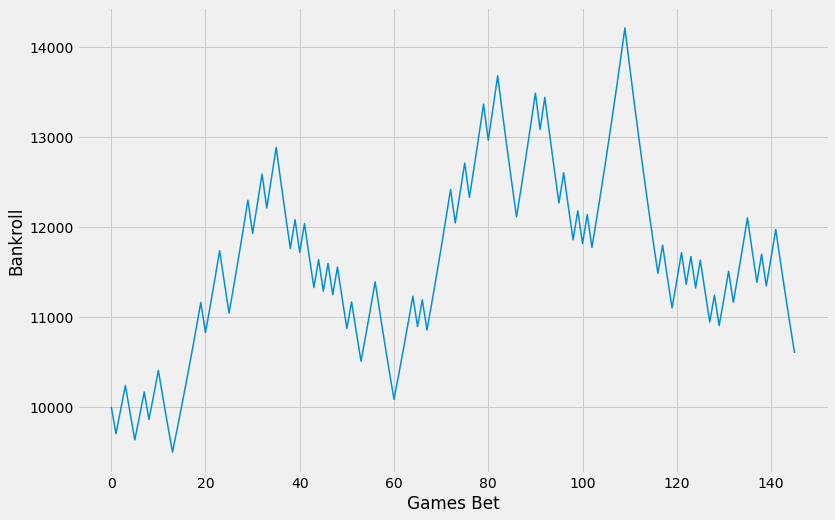

min balance: 9495.474893441879 
max balance: 14210.736110540929 
final balance: 10886.320185706538 
win percentage 54.11


,index,TEAM_ABBREVIATION,point_diff_team,MATCHUP,home_spread_mode,en_preds,home_cover,bet_home,bet_won,bankroll_i,bet_size,bankroll_n
0,1,IND,-4,IND vs. NYK,-9.5,3.723771,0,1,0,10000.000000,300.000000,9700.000000
1,5,DET,-2,DET vs. BOS,8.0,2.559869,1,1,1,9700.000000,291.000000,9964.545455
2,6,BKN,-1,BKN vs. WAS,-7.5,-4.080041,0,0,1,9964.545455,298.936364,10236.305785
3,7,MEM,-14,MEM vs. LAL,10.0,3.573525,0,1,0,10236.305785,307.089174,9929.216612
4,10,PHX,-5,PHX vs. LAC,3.5,2.042165,0,1,0,9929.216612,297.876498,9631.340113
...,...,...,...,...,...,...,...,...,...,...,...,...
141,573,TOR,-4,TOR vs. PHX,3.5,5.471833,0,1,0,11970.392977,359.111789,11611.281188
142,577,NOP,-5,NOP vs. DEN,2.5,2.881363,0,1,0,11611.281188,348.338436,11262.942752
143,587,TOR,-5,TOR vs. POR,2.5,3.269273,0,1,0,11262.942752,337.888283,10925.054470
144,593,HOU,-10,HOU vs. MEM,8.0,3.477994,0,1,0,10925.054470,327.751634,10597.302836


In [224]:
sgd_preds_2020_hd = best_sgd_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
sgd_preds_2020_hf = best_sgd_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])

en_preds_2020_hd = best_en_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
en_preds_2020_hf = best_en_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])


betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['en_preds'] = 0
betting_df_2020.loc[betting_df_2020['home_spread_mode'] >= 0, 'en_preds'] = en_preds_2020_hd
betting_df_2020.loc[betting_df_2020['home_spread_mode'] < 0, 'en_preds'] = en_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['en_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[((betting_df_2020['home_spread_mode'] >= 0) & (abs(betting_df_2020['en_preds']) > 2.))
                                       | ((betting_df_2020['home_spread_mode'] < 0) & (abs(betting_df_2020['en_preds']) > 2))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [384]:
# sgd_preds_2020_hd = sgd_pipe_hd.predict(features_2020.loc[features_2020['home_spread_mode'] > 0])
# sgd_preds_2020_hf = sgd_pipe_hf.predict(features_2020.loc[features_2020['home_spread_mode'] <= 0])

# lgbr_preds_2020 = best_lgbr.predict(features_2020)

# xgb_preds_2020 = xgbr.predict(features_2020)

# rf_preds_2020 = best_rf.predict(features_2020)

# en_preds_2020 = en_pipe.predict(features_2020)

net_preds = net(torch.Tensor(torch_scaler.transform(features_2020))).detach().numpy()

# net_preds

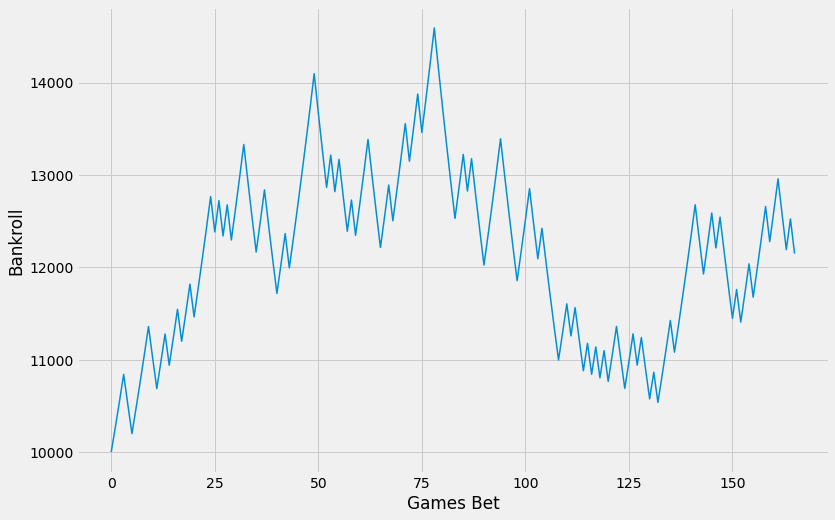

min balance: 10200.013428249435 
max balance: 14590.44129690014 
final balance: 11783.765125935191 
win percentage 54.82


,index,TEAM_ABBREVIATION,point_diff_team,MATCHUP,home_spread_mode,spread+diff,net_preds,home_cover,bet_home,bet_won,bankroll_i,bet_size,bankroll_n
0,3,ATL,-5,ATL vs. CLE,-5.5,-10.5,-7.630116,0,0,1,10000.000000,300.000000,10272.727273
1,4,MIN,-15,MIN vs. DEN,8.5,-6.5,-17.511482,0,0,1,10272.727273,308.181818,10552.892562
2,6,BKN,-1,BKN vs. WAS,-7.5,-8.5,-24.358429,0,0,1,10552.892562,316.586777,10840.698723
3,7,MEM,-14,MEM vs. LAL,10.0,-4.0,10.259763,0,1,0,10840.698723,325.220962,10515.477761
4,8,SAS,-21,SAS vs. UTA,5.5,-15.5,8.119968,0,1,0,10515.477761,315.464333,10200.013428
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,548,MIL,27,MIL vs. IND,-7.0,20.0,-7.958269,1,0,0,12957.206559,388.716197,12568.490362
162,552,MIA,-10,MIA vs. PHX,2.0,-8.0,7.853865,0,1,0,12568.490362,377.054711,12191.435651
163,589,BOS,-6,BOS vs. NOP,-3.0,-9.0,-7.221478,0,0,1,12191.435651,365.743070,12523.929351
164,593,HOU,-10,HOU vs. MEM,8.0,-2.0,8.024974,0,1,0,12523.929351,375.717881,12148.211470


In [385]:
betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['spread+diff'] = betting_df_2020['home_spread_mode'] + betting_df_2020['point_diff_team']
betting_df_2020['net_preds'] = net_preds
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] > 0, 'sgd_preds'] = sgd_preds_2020_hd
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] <= 0, 'sgd_preds'] = sgd_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['net_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[abs(betting_df_2020['net_preds']) > 7]
    
                                       # ((betting_df_2020['home_spread_mode'] > 0) & (abs(betting_df_2020['sgd_preds']) > 1.69))
                                      # | ((betting_df_2020['home_spread_mode'] <= 0) & (abs(betting_df_2020['sgd_preds']) > 3.75))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [371]:
# select_bets_2020.loc[select_bets_2020['net_preds'] > 0]
betting_df_2020.loc[betting_df_2020['net_preds']>0]

,TEAM_ABBREVIATION,point_diff_team,MATCHUP,home_spread_mode,net_preds,home_cover,bet_home,bet_won
14,MIL,10,MIL vs. DET,-16.0,0.176570,0,1,0
25,NOP,-1,NOP vs. OKC,-8.0,0.033497,0,1,0
28,MIL,15,MIL vs. DET,-12.0,0.113456,1,1,1
31,MIA,-2,MIA vs. BOS,-2.5,0.000057,0,1,0
40,POR,18,POR vs. MIN,-10.0,0.032014,1,1,1
49,BOS,9,BOS vs. WAS,-3.5,0.029540,1,1,1
56,MIN,-3,MIN vs. SAS,3.5,0.087571,1,1,1
61,HOU,-18,HOU vs. LAL,3.5,0.029953,0,1,0
62,NYK,-25,NYK vs. DEN,5.5,0.009299,0,1,0
63,LAC,3,LAC vs. CHI,-12.5,0.000713,0,1,0


In [ ]:
simulate_bets(sgd_preds_2020)

## Make Predictions

ETL Pipeline

### Update Date

In [441]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


updating scoring boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.50s/it]


updating tracking boxscores
Updating 10 Games


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.00s/it]


### Get Todays Betting Data

In [442]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


,away_team,home_team,game_date,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,DAL,WAS,2021-04-03,-4.5-110,-4.5-112,-4.5,-4.5,4.5,4.5,4.5,4.5,-4.5,4.5
1,CLE,MIA,2021-04-03,12-110,12-108,12.5,12.0,-12.0,-12.0,-12.5,-12.0,12.5,-12.0
2,MIN,PHI,2021-04-03,13-110,12-110,13.5,13.0,-13.0,-12.0,-13.5,-13.0,13-110,-13.0
3,NYK,DET,2021-04-03,-1.5-110,-1.5-113,-1.5,-1.5,1.5,1.5,1.5,1.5,-1.5,1.5
4,IND,SAS,2021-04-03,6-110,4.5-113,5.5,6.0,-6.0,-4.5,-5.5,-6.0,6-110,-6.0
5,ORL,UTA,2021-04-03,15-110,15-110,15.0,14.5,-15.0,-15.0,-15.0,-14.5,15-110,-15.0
6,MIL,SAC,2021-04-03,-6-105,-6.5-110,-5.5,-5.5,6.0,6.5,5.5,5.5,-5.5,5.5
7,OKC,POR,2021-04-03,11.5-110,11.5-105,11.5,11.5,-11.5,-11.5,-11.5,-11.5,11.5,-11.5


In [443]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data('2020-21')

In [444]:
def get_team_and_opp_ewm_for_model(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'MIN_team', 'home_spread_mode', 'RECORD_team', 'team_covered', 'FG2M_team', 'FG2A_team',
       'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
       'DREB_team', 'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team',
       'PF_team', 'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team',
       'OFF_RATING_team', 'E_DEF_RATING_team', 'DEF_RATING_team',
       'E_NET_RATING_team', 'NET_RATING_team', 'POSS_team', 'PIE_team',
       'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team',
       'AST_2PM_team', 'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team',
       'SEASON_YEAR_opp', 'SEASON_ID_opp', 'TEAM_ID_opp',
       'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
       'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 'point_diff_opp',
       'WL_opp', 'MIN_opp', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
       'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
       'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp',
       'PLUS_MINUS_opp', 'E_OFF_RATING_opp', 'OFF_RATING_opp',
       'E_DEF_RATING_opp', 'DEF_RATING_opp', 'E_NET_RATING_opp',
       'NET_RATING_opp', 'POSS_opp', 'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp',
       'PTS_OFF_TOV_opp', 'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp',
       'AST_3PM_opp', 'UAST_3PM_opp', 'home_team', 'away_team', 'game_date',
       'away_spread_mode']]
    
    df = df.drop(columns = ['SEASON_YEAR_opp', 'SEASON_ID_opp', 
                            'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                            'TEAM_NAME_opp', 'GAME_DATE_opp', 
                            'MATCHUP_opp', 'WL_opp', 'HOME_GAME_opp',
                           'point_diff_opp', 'home_team', 'away_team', 'game_date',
                           'away_spread_mode'])
    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        team_record = team_df['RECORD_team'].shift(1).expanding().mean()
        ATS_rec = team_df['team_covered'].shift(1).expanding().mean()
        records_df = pd.DataFrame({'WL_record':team_record, 
                                  'ATS_record':ATS_rec})

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records_df], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df


In [445]:
def add_rest_days_for_model(df):
    df['rest'] = np.nan
    for season in df['SEASON_YEAR_team'].unique():
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['rest'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'rest'] = team_df['rest']
            
    return df

In [446]:
df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)
df1

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,home_spread_mode,WL_record,ATS_record,RECORD_team,team_covered,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,TEAM_SCORE_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_team,OREB_PCT_opp,DREB_PCT_team,DREB_PCT_opp,REB_PCT_team,REB_PCT_opp,TS_PCT_team,TS_PCT_opp,EFG_PCT_team,EFG_PCT_opp,AST_RATIO_team,AST_RATIO_opp,TOV_PCT_team,TOV_PCT_opp,rest
0,2020-21,22020,1610612746,LAC,LA Clippers,22000002,2020-12-22,LAC @ LAL,0,116,7,1,240,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-21,22020,1610612746,LAC,LA Clippers,22000009,2020-12-25,LAC @ DEN,0,121,13,1,240,4.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,2020-21,22020,1610612746,LAC,LA Clippers,22000031,2020-12-27,LAC vs. DAL,1,73,-51,0,240,-3.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2020-21,22020,1610612746,LAC,LA Clippers,22000054,2020-12-29,LAC vs. MIN,1,124,23,1,240,-11.0,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,2020-21,22020,1610612746,LAC,LA Clippers,22000061,2020-12-30,LAC vs. POR,1,128,23,1,240,-6.0,0.750000,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,2020-21,22020,1610612760,OKC,Oklahoma City Thunder,22000654,2021-03-22,OKC @ MIN,0,112,9,1,240,-5.0,0.428571,0.523810,0.462632,0.503451,26.23062

In [447]:
df1

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,home_spread_mode,WL_record,ATS_record,RECORD_team,team_covered,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,TEAM_SCORE_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_team,OREB_PCT_opp,DREB_PCT_team,DREB_PCT_opp,REB_PCT_team,REB_PCT_opp,TS_PCT_team,TS_PCT_opp,EFG_PCT_team,EFG_PCT_opp,AST_RATIO_team,AST_RATIO_opp,TOV_PCT_team,TOV_PCT_opp,rest
0,2020-21,22020,1610612746,LAC,LA Clippers,22000002,2020-12-22,LAC @ LAL,0,116,7,1,240,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-21,22020,1610612746,LAC,LA Clippers,22000009,2020-12-25,LAC @ DEN,0,121,13,1,240,4.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,2020-21,22020,1610612746,LAC,LA Clippers,22000031,2020-12-27,LAC vs. DAL,1,73,-51,0,240,-3.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2020-21,22020,1610612746,LAC,LA Clippers,22000054,2020-12-29,LAC vs. MIN,1,124,23,1,240,-11.0,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,2020-21,22020,1610612746,LAC,LA Clippers,22000061,2020-12-30,LAC vs. POR,1,128,23,1,240,-6.0,0.750000,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,2020-21,22020,1610612760,OKC,Oklahoma City Thunder,22000654,2021-03-22,OKC @ MIN,0,112,9,1,240,-5.0,0.428571,0.523810,0.462632,0.503451,26.23062

In [448]:
prev_season_final_elo = {}
for team in full_df_ewm_19['TEAM_ABBREVIATION'].unique():
    team_df = full_df_ewm_19.loc[full_df_ewm_19['MATCHUP'].str.contains(team)].sort_values('GAME_DATE').reset_index(drop=True)
    if team_df.loc[team_df.shape[0]-1, 'MATCHUP'][:3] == team:
        final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    else:
        final_elo = team_df.loc[team_df.shape[0]-1, 'away_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'IND': 1529.4483384275268,
 'HOU': 1540.8964001636646,
 'POR': 1500.1407073118096,
 'LAL': 1684.3757506350337,
 'CLE': 1298.0343645791245,
 'SAS': 1522.744349117492,
 'MIN': 1340.3072979400008,
 'CHI': 1332.027526532048,
 'MIL': 1629.7867944120128,
 'GSW': 1360.7007973857746,
 'SAC': 1516.141852484055,
 'LAC': 1626.6462653315195,
 'MIA': 1618.0421597762124,
 'BOS': 1703.07997468606,
 'NYK': 1326.2237584707232,
 'ATL': 1337.167197222995,
 'NOP': 1499.3615728404923,
 'DAL': 1544.6886733768054,
 'UTA': 1549.7536707979227,
 'DET': 1342.6198199001185,
 'ORL': 1490.8373868097253,
 'BKN': 1467.7010014887078,
 'PHX': 1536.6695679529985,
 'MEM': 1553.2535462864591,
 'DEN': 1584.84073526912,
 'WAS': 1380.5107315006996,
 'CHA': 1394.9240309027477,
 'PHI': 1552.491927190443,
 'TOR': 1676.213996740524,
 'OKC': 1560.4746669932429}

In [449]:
with open("../data/final_elo_2020.pkl", 'wb') as file:
    pickle.dump(prev_season_final_elo, file)
    

In [450]:
# Add ELO ratings
with open("../data/final_elo_2020.pkl", "rb") as file:
    final_elo_2020 = pickle.load(file)


def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME_team'] == 1]
    # Initialize the following columns
    df = df.sort_values('GAME_DATE_team')

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP_team'][:3]
        away_team_abbr = row['MATCHUP_team'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[home_team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)


progress:: 713it [00:01, 594.18it/s]


In [451]:
sorted(list(elo_ratings_dic.items()), key=lambda x: x[1], reverse=True)

[('UTA', 1695.1116127688701),
 ('DEN', 1643.9932061267505),
 ('PHX', 1643.2505280213047),
 ('PHI', 1641.91906223637),
 ('MIL', 1636.6251277234726),
 ('LAC', 1617.9483674908743),
 ('BKN', 1609.0970800387167),
 ('DAL', 1600.6323347879759),
 ('LAL', 1594.685823621672),
 ('ATL', 1549.0858878760444),
 ('CHA', 1529.246188892717),
 ('MEM', 1529.1740586616115),
 ('MIA', 1522.2233032905194),
 ('POR', 1509.5329643682226),
 ('BOS', 1508.5640846888216),
 ('IND', 1506.1032699853033),
 ('TOR', 1484.370998943311),
 ('NOP', 1460.0619221119289),
 ('NYK', 1459.8277688751557),
 ('SAC', 1454.8135939558026),
 ('SAS', 1445.5081664753009),
 ('GSW', 1443.6002087162024),
 ('CHI', 1422.7871491263463),
 ('OKC', 1406.9973753498114),
 ('DET', 1402.306882583506),
 ('ORL', 1388.455298586604),
 ('WAS', 1371.5658080238677),
 ('CLE', 1342.7394090393968),
 ('MIN', 1326.6109047226719),
 ('HOU', 1290.7402598053923)]

In [452]:
def create_matchup_rows_for_model(df, away_team, home_team, spread, current_elo_dic):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                      'SEASON_ID_team':'SEASON_ID',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df.sort_values(['GAME_DATE'], inplace=True)
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    home_stats.at[home_stats.shape[0]-1, 'rest'] = (datetime.today() - home_stats.at[home_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)
    away_stats.at[away_stats.shape[0]-1, 'rest'] = (datetime.today() - away_stats.at[away_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')

    diffs = home_stats.iloc[-1, 14:] - away_stats.iloc[-1, 14:]
    diffs = diffs.values.reshape(1, -1)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:]]
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
        
    diffs['home_rating_i'] = current_elo_dic[home_team]
    diffs['away_rating_i'] = current_elo_dic[away_team]
    diffs['home_elo_pred'] = 1.0/(1 + 10 ** (( diffs['away_rating_i'] - diffs['home_rating_i']) / (400.0)))

    diffs['elo_MOV_pred'] = round((diffs['home_rating_i']+100 - diffs['away_rating_i'])/28, 2)
    diffs['home_spread_mode'] = spread 
    
    diffs = diffs[X_train_ewm_19.columns]
    
    return diffs

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)

,home_spread_mode,WL_record_diff,ATS_record_diff,RECORD_team_diff,team_covered_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,OFF_RATING_team_diff,E_DEF_RATING_team_diff,DEF_RATING_team_diff,E_NET_RATING_team_diff,NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,TEAM_SCORE_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,DEF_RATING_opp_diff,E_NET_RATING_opp_diff,NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff,rest_diff,home_elo_pred,home_rating_i,away_rating_i,elo_MOV_pred
0,-3,-0.179463,-0.0744681,-0.130346,0.0100565,0.771314,1.38298,-0.000764037,3.60108,1.18658,0.615254,-0.3409,-3.48034,-3.82125,3.28415,2.38366,0.670353,-2.05369,3.52316,2.72691,-0.580535,-0.945318,1.11265,-0.177191,1.1315,-0.786312,-0.0324955,1.48803,-0.00496232,-1.20019,3.19163,4.46767,2.72338,2.67205,-1.99951,0.718132,-0.695025,3.30745,0.130346,-0.135756,1.99365,0.416147,-3.4697,2.33052,2.30673,-0.00117765,2.07533,2.07415,2.90665,-2.29005,0.671452,3.54816,0.931445,3.30745,0.580535,-0.177191,1.1315,-0.945318,1.11265,0.786312,0.0324955,1.81846,0.00496232,1.39736,3.59304,-4.42725,-1.72532,2.22005,-2.37193,0.657797,-0.346865,-0.0158015,0.017094,-0.017094,0.0158015,-0.0326693,0.0326693,-0.0169042,0.0238796,-0.0201873,0.0145145,2.89928,2.42549,-2.17765,2.81216,0,0.386336,1326.610905,1406.997375,0.7


### Make Predictions

In [453]:
todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


,away_team,home_team,game_date,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,DAL,WAS,2021-04-03,-4.5-110,-4.5-112,-4.5,-4.5,4.5,4.5,4.5,4.5,-4.5,4.5
1,CLE,MIA,2021-04-03,12-110,12-108,12.5,12.0,-12.0,-12.0,-12.5,-12.0,12.5,-12.0
2,MIN,PHI,2021-04-03,13-110,12-110,13.5,13.0,-13.0,-12.0,-13.5,-13.0,13-110,-13.0
3,NYK,DET,2021-04-03,-1.5-110,-1.5-113,-1.5,-1.5,1.5,1.5,1.5,1.5,-1.5,1.5
4,IND,SAS,2021-04-03,6-110,4.5-113,5.5,6.0,-6.0,-4.5,-5.5,-6.0,6-110,-6.0
5,ORL,UTA,2021-04-03,15-110,15-110,15.0,14.5,-15.0,-15.0,-15.0,-14.5,15-110,-15.0
6,MIL,SAC,2021-04-03,-6-105,-6.5-110,-5.5,-5.5,6.0,6.5,5.5,5.5,-5.5,5.5
7,OKC,POR,2021-04-03,11.5-110,11.5-105,11.5,11.5,-11.5,-11.5,-11.5,-11.5,11.5,-11.5


In [39]:
# Load Models

with open('../models/sgd_ewm_19.pkl', 'rb') as f:
    sgd_pipe = pickle.load(f)
    
with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
    best_lgbr = pickle.load(f)
    
with open('../models/xgb_ewm_19.pkl', 'rb') as f:
    best_xgbr = pickle.load(f)
    
with open('../models/rf_ewm_19.pkl', 'rb') as f:
    best_rf = pickle.load(f)
    
with open('../models/en_ewm_19.pkl', 'rb') as f:
    en_pipe = pickle.load(f)
    
with open("../models/lasso_ewm_19.pkl", 'rb') as f:
    lasso_pipe = pickle.load(f)

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


,home_spread_mode,WL_record_diff,ATS_record_diff,RECORD_team_diff,team_covered_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,OFF_RATING_team_diff,E_DEF_RATING_team_diff,DEF_RATING_team_diff,E_NET_RATING_team_diff,NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,TEAM_SCORE_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,DEF_RATING_opp_diff,E_NET_RATING_opp_diff,NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff,rest_diff,home_elo_pred,home_rating_i,away_rating_i,elo_MOV_pred
0,-3,-0.183092,-0.0763285,-0.144892,0.011143,1.19352,2.20987,-0.000726966,3.2203,1.87994,1.69273,0.741648,-2.30137,-1.55972,2.97972,1.86619,0.521539,-1.49935,4.14165,4.2648,0.363874,0.192724,2.11145,0.115911,1.12315,0.0677887,0.984322,1.99059,-0.00237432,-1.44673,3.10111,3.84759,3.58807,2.97124,-1.88749,0.0143575,-0.100572,3.90093,0.144892,-1.1599,0.536119,1.02301,-1.28157,3.15171,2.90113,-0.00155193,1.63512,1.63357,3.34388,-1.87421,0.858817,2.82509,1.82035,3.90093,-0.363874,0.115911,1.12315,0.192724,2.11145,-0.0677887,-0.984322,2.35787,0.00237432,0.095416,3.99595,-3.6913,-2.36804,2.24413,-3.42199,1.1797,-0.161641,0.00481673,0.0116754,-0.0116754,-0.00481673,-0.017652,0.017652,-0.0128075,0.0213821,-0.017978,0.00875831,2.4739,2.70151,-1.85381,2.1216,0,0.383526,1329.036655,1411.484854,0.63


In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


,away_team,home_team,spread,game_date,net_pred
0,DAL,WAS,4.5,2021-04-03,[-2.0314543]
1,CLE,MIA,-12.0,2021-04-03,[-0.7431023]
2,MIN,PHI,-13.0,2021-04-03,[-2.774469]
3,NYK,DET,1.5,2021-04-03,[0.21155608]
4,IND,SAS,-6.0,2021-04-03,[-1.0953536]
5,ORL,UTA,-15.0,2021-04-03,[-0.026118085]
6,MIL,SAC,5.5,2021-04-03,[0.10418765]
7,OKC,POR,-11.5,2021-04-03,[-2.474314]


In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df